# Load Data
- Initialized test, validation, and training sets


In [ ]:
import torch
import requests
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, random_split

trainingURL = "https://www.cs.fsu.edu/~liux/courses/deepRL/assignments/zip_train.txt"
testURL = "https://www.cs.fsu.edu/~liux/courses/deepRL/assignments/zip_test.txt"


trainResponse = requests.get(trainingURL)
with open("zip_train.txt", "wb") as f:
    f.write(trainResponse.content)


testResponse = requests.get(testURL)
with open("zip_test.txt", "wb") as f:
    f.write(testResponse.content)

trainingData = np.loadtxt("zip_train.txt")
testData = np.loadtxt("zip_test.txt")

xTrain = torch.tensor(trainingData[:, 1:], dtype=torch.float32)
yTrain = torch.tensor(trainingData[:, 0], dtype=torch.long)
dataSet = TensorDataset(xTrain, yTrain)
trainSize = int(0.8 * len(dataSet))
valSize = len(dataSet) - trainSize
xTest = torch.tensor(testData[:, 1:], dtype=torch.float32)
yTest = torch.tensor(testData[:, 0], dtype=torch.long)

# Training, validation, and test sets used
testSet = TensorDataset(xTest, yTest)
trainingSet, validationSet = random_split(dataSet, [trainSize, valSize])



# Example

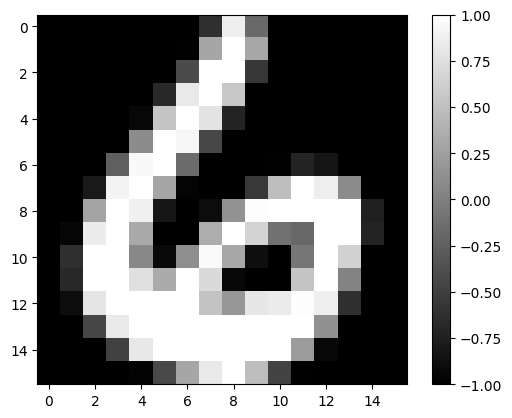

In [ ]:

sample_index = 0
sample_image = xTrain[sample_index].numpy()
sample_label = yTrain[sample_index].item()

plt.imshow(sample_image.reshape(16, 16), cmap="gray")
plt.colorbar()
plt.savefig("sample_image.png", dpi=300)
plt.show()

# Base Functions:
-  Model Creation, Testing, Training, and Validating

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import random
from torch.nn.modules.utils import _pair
import torch.nn as nn
import torch.nn.functional as F
import torch

# CNN
class CNNModel(nn.Module):
    def __init__(self, initials="effective", dropout_p=0.5):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=dropout_p)


        self.initialize_weights(initials)

    def initialize_weights(self, initials):
        for layer in self.modules():
            if isinstance(layer, (nn.Conv2d, nn.Linear)):
                if initials == "slow":
                    nn.init.uniform_(layer.weight, -0.001, 0.001)
                elif initials == "effective":
                    nn.init.xavier_uniform_(layer.weight)
                elif initials == "fast":
                    nn.init.uniform_(layer.weight, 100000, 200000)

                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.tanh(self.fc1(x)))
        x = self.fc2(x)
        return x


# Locally Connected:
class LocallyConnected2d(nn.Module):
    def __init__(self, in_channels, out_channels, output_size, kernel_size, stride, bias=False):
        super(LocallyConnected2d, self).__init__()
        output_size = _pair(output_size)
        self.weight = nn.Parameter(
            torch.randn(1, out_channels, in_channels, output_size[0], output_size[1], kernel_size**2)
        )
        if bias:
            self.bias = nn.Parameter(
                torch.randn(1, out_channels, output_size[0], output_size[1])
            )
        else:
            self.register_parameter('bias', None)
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)

    def forward(self, x):
        _, c, h, w = x.size()
        kh, kw = self.kernel_size
        dh, dw = self.stride
        x = x.unfold(2, kh, dh).unfold(3, kw, dw)
        x = x.contiguous().view(*x.size()[:-2], -1)

        out = (x.unsqueeze(1) * self.weight).sum([2, -1])

        if self.bias is not None:
            out += self.bias

        return out

class LocallyConnectedNN(nn.Module):
    def __init__(self, initials="effective", dropout_p=0.5):
        super(LocallyConnectedNN, self).__init__()

        self.locally_connected1 = LocallyConnected2d(in_channels=1, out_channels=8, output_size=(14, 14), kernel_size=3, stride=1)
        self.locally_connected2 = LocallyConnected2d(in_channels=8, out_channels=16, output_size=(6, 6), kernel_size=3, stride=2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=dropout_p)

        self.initialize_weights(initials)

    def initialize_weights(self, initials):
        for layer in self.modules():
            if isinstance(layer, (LocallyConnected2d, nn.Linear)):
                if initials == "slow":
                    nn.init.uniform_(layer.weight, -0.001, 0.001)
                elif initials == "effective":
                    nn.init.xavier_uniform_(layer.weight)
                elif initials == "fast":
                    nn.init.uniform_(layer.weight, 1000000, 2000000)

                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        x = x.view(x.size(0), 1, 16, 16)
        x = F.relu(self.locally_connected1(x))
        x = self.pool(F.relu(self.locally_connected2(x)))
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = self.dropout(F.tanh(self.fc1(x)))
        x = self.fc2(x)
        return x

#  MLP
def InitializeWeights(initials, modelType):
    if modelType == 1:
      W1 = torch.empty(256, 128, dtype=torch.float32, requires_grad=True)
      W2 = torch.empty(128, 64, dtype=torch.float32, requires_grad=True)
      W3 = torch.empty(64, 32, dtype=torch.float32, requires_grad=True)
      W4 = torch.empty(32, 10, dtype=torch.float32, requires_grad=True)

    elif modelType == 2:
        W1 = torch.empty(256, 64, dtype=torch.float32, requires_grad=True)
        W2 = torch.empty(64, 32, dtype=torch.float32, requires_grad=True)
        W3 = torch.empty(32, 16, dtype=torch.float32, requires_grad=True)
        W4 = torch.empty(16, 10, dtype=torch.float32, requires_grad=True)


    b1 = torch.empty(W1.shape[1], dtype=torch.float32, requires_grad=True)
    b2 = torch.empty(W2.shape[1], dtype=torch.float32, requires_grad=True)
    b3 = torch.empty(W3.shape[1], dtype=torch.float32, requires_grad=True)
    b4 = torch.empty(10, dtype=torch.float32, requires_grad=True)

    if initials == "slow":
        torch.nn.init.uniform_(W1, -0.001, 0.001)
        torch.nn.init.uniform_(W2, -0.001, 0.001)
        torch.nn.init.uniform_(W3, -0.001, 0.001)
        torch.nn.init.uniform_(W4, -0.001, 0.001)

    elif initials == "effective":
        torch.nn.init.xavier_uniform_(W1)
        torch.nn.init.xavier_uniform_(W2)
        torch.nn.init.xavier_uniform_(W3)
        torch.nn.init.xavier_uniform_(W4)

    elif initials == "fast":
        torch.nn.init.uniform_(W1, 10, 20)
        torch.nn.init.uniform_(W2, 10, 20)
        torch.nn.init.uniform_(W3, 10, 20)
        torch.nn.init.uniform_(W4, 10, 20)

    torch.nn.init.zeros_(b1)
    torch.nn.init.zeros_(b2)
    torch.nn.init.zeros_(b3)
    torch.nn.init.zeros_(b4)

    return W1, b1, W2, b2, W3, b3, W4, b4

def Model(X, W1, b1, W2, b2, W3, b3, W4, b4, dropout_p=0.5, training=True, modelType = 1):
    if modelType == 1:
      h1 = F.relu(X @ W1 + b1)
      if training:
          h1 = F.dropout(h1, p=dropout_p, training=training)
      h2 = torch.sigmoid(h1 @ W2 + b2)
      if training:
          h2 = F.dropout(h2, p=dropout_p, training=training)
      h3 = F.relu(h2 @ W3 + b3)
      if training:
          h3 = F.dropout(h3, p=dropout_p, training=training)
      y_pred = F.softmax(h3 @ W4 + b4, dim=1)

    return y_pred

lossFunction = nn.CrossEntropyLoss()

# Training
def TrainModel(W1, b1, W2, b2, W3, b3, W4, b4, learningRate, mom, bs, trainLoader, dropout_p, modelType):
    optimizer = optim.SGD([W1, b1, W2, b2, W3, b3, W4, b4], lr=learningRate, momentum=mom)
    epochs = 20       #20
    gradientMagnitudes = []
    trainingLosses = []

    for epoch in range(epochs):
        total_loss = 0.0
        epochGradientMagnitudes = []
        num_batches = 0

        for xBatch, yBatch in trainLoader:
            optimizer.zero_grad()
            ypred = Model(xBatch, W1, b1, W2, b2, W3, b3, W4, b4, dropout_p, training=True, modelType = modelType)
            loss = lossFunction(ypred, yBatch)
            loss.backward()
            grad_norms = [W1.grad.norm().item(), W2.grad.norm().item(), W3.grad.norm().item(), W4.grad.norm().item()]
            grad_avg_norms = sum(grad_norms) / len(grad_norms)
            epochGradientMagnitudes.append(grad_avg_norms)
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1

        avg_epoch_loss = total_loss / num_batches if num_batches > 0 else 0
        trainingLosses.append(avg_epoch_loss)

        gradientMagnitudes.append(sum(epochGradientMagnitudes)/len(epochGradientMagnitudes))
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.6f}")

    return (W1, b1, W2, b2, W3, b3, W4, b4), gradientMagnitudes, trainingLosses

def TrainCNN(model, learningRate, mom, trainLoader):
    optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=mom)
    epochs =20
    gradientMagnitudes = []
    trainingLosses = []

    for epoch in range(epochs):
        total_loss = 0.0
        epochGradientMagnitudes = []
        num_batches = 0

        for xBatch, yBatch in trainLoader:
            optimizer.zero_grad()
            xBatch = xBatch.view(-1, 1, 16, 16)
            ypred = model(xBatch)
            loss = lossFunction(ypred, yBatch)
            loss.backward()
            grad_norms = [param.grad.norm().item() for param in model.parameters()]
            avg_grad_norm = sum(grad_norms) / len(grad_norms)
            epochGradientMagnitudes.append(avg_grad_norm)
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1

        avg_epoch_loss = total_loss / num_batches if num_batches > 0 else 0
        trainingLosses.append(avg_epoch_loss)
        gradientMagnitudes.append(sum(epochGradientMagnitudes)/len(epochGradientMagnitudes))
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.6f}")

    return model, gradientMagnitudes, trainingLosses

def train_LCNN(model, learningRate, mom, trainLoader):
    optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=mom)
    epochs = 20
    gradientMagnitudes = []
    trainingLosses = []

    for epoch in range(epochs):
        total_loss = 0.0
        epochGradientMagnitudes = []
        num_batches = 0

        for xBatch, yBatch in trainLoader:
            optimizer.zero_grad()
            xBatch = xBatch.view(xBatch.size(0), 1, 256)
            ypred = model(xBatch)
            loss = lossFunction(ypred, yBatch)
            loss.backward()
            grad_norms = [param.grad.norm().item() for param in model.parameters()]
            avg_grad_norm = sum(grad_norms) / len(grad_norms)
            epochGradientMagnitudes.append(avg_grad_norm)
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1

        avg_epoch_loss = total_loss / num_batches if num_batches > 0 else 0
        trainingLosses.append(avg_epoch_loss)
        gradientMagnitudes.append(sum(epochGradientMagnitudes) / len(epochGradientMagnitudes))

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.6f}")

    return model, gradientMagnitudes, trainingLosses

# Valiation
def ValidateModel(W1, b1, W2, b2, W3, b3, W4, b4, valLoader, dropout_p, modelType):
    correct, total = 0, 0
    with torch.no_grad():
        for xBatch, yBatch in valLoader:
            ypred = Model(xBatch, W1, b1, W2, b2, W3, b3, W4, b4, dropout_p, training=False, modelType = modelType)
            _, predicted = torch.max(ypred, 1)
            total += yBatch.size(0)
            correct += (predicted == yBatch).sum().item()

    return 100 * correct / total

def ValidateCNN(model, valLoader):
    correct, total = 0, 0
    with torch.no_grad():
        for xBatch, yBatch in valLoader:
            xBatch = xBatch.view(-1, 1, 16, 16)
            ypred = model(xBatch)
            _, predicted = torch.max(ypred, 1)
            total += yBatch.size(0)
            correct += (predicted == yBatch).sum().item()

    return 100 * correct / total

def ValidateLCNN(model, valLoader):
    correct, total = 0, 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for xBatch, yBatch in valLoader:
            xBatch, yBatch = xBatch.to(device), yBatch.to(device)
            xBatch = xBatch.view(xBatch.size(0), 1, 256)  # Reshape for LCNN input
            ypred = model(xBatch)
            _, predicted = torch.max(ypred, 1)
            total += yBatch.size(0)
            correct += (predicted == yBatch).sum().item()

    model.to("cpu")
    return 100 * correct / total


# Testing
def TestModel(W1, b1, W2, b2, W3, b3, W4, b4, testLoader, dropout_p, modelType):
    correct, total = 0, 0
    with torch.no_grad():
        for xBatch, yBatch in testLoader:
            ypred = Model(xBatch, W1, b1, W2, b2, W3, b3, W4, b4, dropout_p, training=False, modelType = modelType)
            _, predicted = torch.max(ypred, 1)
            total += yBatch.size(0)
            correct += (predicted == yBatch).sum().item()

    return 100 * correct / total

def TestCNN(model, testLoader):
    correct, total = 0, 0
    with torch.no_grad():
        for xBatch, yBatch in testLoader:
            xBatch = xBatch.view(-1, 1, 16, 16)
            ypred = model(xBatch)
            _, predicted = torch.max(ypred, 1)
            total += yBatch.size(0)
            correct += (predicted == yBatch).sum().item()

    return 100 * correct / total

def TestLCNN(model, testLoader):
    correct, total = 0, 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for xBatch, yBatch in testLoader:
            xBatch, yBatch = xBatch.to(device), yBatch.to(device)
            xBatch = xBatch.view(xBatch.size(0), 1, 256)
            ypred = model(xBatch)
            _, predicted = torch.max(ypred, 1)
            total += yBatch.size(0)
            correct += (predicted == yBatch).sum().item()

    model.to("cpu")
    return 100 * correct / total

# Model Summary for LCNN and CNN

In [ ]:
import torch
from torchsummary import summary


input_shape = (1, 16, 16)  # (channels, height, width)

lcnn_model = LocallyConnectedNN(initials="effective", dropout_p=0.5)
cnn_model = CNNModel(initials="effective", dropout_p=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lcnn_model.to(device)
cnn_model

print("----- SUMMARY FOR LCNN: -----")
summary(lcnn_model, input_size=input_shape)
print("----- SUMMARY FOR CNN: -----")
summary(cnn_model, input_size=input_shape)


----- SUMMARY FOR LCNN: -----
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
LocallyConnected2d-1            [-1, 8, 14, 14]          14,112
LocallyConnected2d-2             [-1, 16, 6, 6]          41,472
         MaxPool2d-3             [-1, 16, 3, 3]               0
            Linear-4                  [-1, 128]          18,560
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 75,434
Trainable params: 75,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.29
Estimated Total Size (MB): 0.31
----------------------------------------------------------------
----- SUMMARY FOR CNN: -----
----------------------------------------------------------------
        Layer (type)               Output Shape 

# Coarse Optimzation with Random Search


In [ ]:
import random
import pandas as pd

def SampleHyperparameters():
    learningRate = random.uniform(1e-7, 1e-1)
    batchSize = random.choice([16, 32, 64, 128])
    momentum = random.uniform(.5, .99)
    dropout_p = random.uniform(.1, .7)
    return learningRate, batchSize, momentum, dropout_p

trials = 30
initials = "effective"

def CoarseRandomSearch(initials, trials, modelType):
    bestCoarseHyperParameters = None
    bestParameters = None
    bestValidationAccuracy = 0
    results = []

    for i in range(trials):
        lr, bs, mom, dropout_p = SampleHyperparameters()
        trainLoader = DataLoader(trainingSet, batch_size=bs, shuffle=True)
        valLoader = DataLoader(validationSet, batch_size=bs, shuffle=False)

        if modelType == 1:
            W1, b1, W2, b2, W3, b3, W4, b4 = InitializeWeights(initials, modelType=modelType)
            trained_parameters, _ = TrainModel(W1, b1, W2, b2, W3, b3, W4, b4, lr, mom, bs, trainLoader, dropout_p, modelType=modelType)
            validation_accuracy = ValidateModel(*trained_parameters, valLoader, dropout_p, modelType=modelType)
        elif modelType == 2:
            model = LocallyConnectedNN(initials=initials, dropout_p=dropout_p)
            trained_model, _, _ = train_LCNN(model, lr, mom, trainLoader)
            validation_accuracy = ValidateLCNN(trained_model, valLoader)
        elif modelType == 3:
            model = CNNModel(initials=initials, dropout_p=dropout_p)
            trained_model, _, _ = TrainCNN(model, lr, mom, trainLoader)
            validation_accuracy = ValidateCNN(trained_model, valLoader)


        results.append({
            "trial": i + 1,
            "validation_accuracy": validation_accuracy,
            "learning_rate": lr,
            "batch_size": bs,
            "momentum": mom,
            "dropout": dropout_p,
            "model_type": modelType
        })

        print(f"Trial {i+1} for Model {modelType}: Validation Accuracy = {validation_accuracy:.2f}% | Dropout = {dropout_p}, Momentum = {mom}, LR = {lr}, Batch Size={bs}")

        if bestValidationAccuracy < validation_accuracy:
            bestValidationAccuracy = validation_accuracy
            bestCoarseHyperParameters = (lr, mom, bs, dropout_p)
            bestParameters = trained_parameters if modelType == 1 else trained_model

    results_df = pd.DataFrame(results)

    return bestCoarseHyperParameters, bestParameters, bestValidationAccuracy, results_df

best1CoarseHyperParameters, best1Parameters, best1ValidationAccuracy, results_1df = CoarseRandomSearch(initials, trials, modelType=1)
best2CoarseHyperParameters, best2Parameters, best2ValidationAccuracy, results_2df = CoarseRandomSearch(initials, trials, modelType=2)
best3CoarseHyperParameters, best3Parameters, best3ValidationAccuracy, results_3df = CoarseRandomSearch(initials, trials, modelType=3)

results_1df.to_csv("coarse1_search_results.csv", index=False)
results_2df.to_csv("coarse2_search_results.csv", index=False)
results_3df.to_csv("coarse3_search_results.csv", index=False)
torch.save(best1Parameters, "best_model_1.pth")
torch.save(best2Parameters.state_dict(), "best_model_2.pth")
torch.save(best3Parameters.state_dict(), "best_model_3.pth")




Epoch 5/20, Loss: 188.781489
Epoch 10/20, Loss: 176.264755
Epoch 15/20, Loss: 168.866399
Epoch 20/20, Loss: 164.115747
Trial 1 for Model 1: Validation Accuracy = 71.97% | Dropout = 0.24102185508312277, Momentum = 0.8103454989413723, LR = 0.01946246442986572, Batch Size=64
Epoch 5/20, Loss: 613.444173
Epoch 10/20, Loss: 588.084307
Epoch 15/20, Loss: 582.441170
Epoch 20/20, Loss: 579.738956
Trial 2 for Model 1: Validation Accuracy = 86.57% | Dropout = 0.3908340780299999, Momentum = 0.9076614986828453, LR = 0.018015587532582325, Batch Size=16
Epoch 5/20, Loss: 682.008588
Epoch 10/20, Loss: 631.195761
Epoch 15/20, Loss: 620.480273
Epoch 20/20, Loss: 615.345155
Trial 3 for Model 1: Validation Accuracy = 80.19% | Dropout = 0.5253048390143604, Momentum = 0.913243617209091, LR = 0.017380917436082294, Batch Size=16
Epoch 5/20, Loss: 422.719033
Epoch 10/20, Loss: 422.055269
Epoch 15/20, Loss: 421.439817
Epoch 20/20, Loss: 421.117050
Trial 4 for Model 1: Validation Accuracy = 22.34% | Dropout = 0

# Reload Optimized Hyperparameters and Models
- Implemented to avoid rerunning another random search

In [ ]:
# Load Best Hyperparameters
results_1df = pd.read_csv("coarse1_search_results.csv")
results_2df = pd.read_csv("coarse2_search_results.csv")
results_3df = pd.read_csv("coarse3_search_results.csv")

best1_row = results_1df.loc[results_1df["validation_accuracy"].idxmax()]
best2_row = results_2df.loc[results_2df["validation_accuracy"].idxmax()]
best3_row = results_3df.loc[results_3df["validation_accuracy"].idxmax()]

best1CoarseHyperParameters = (best1_row["learning_rate"], best1_row["momentum"], int(best1_row["batch_size"]), best1_row["dropout"])
best2CoarseHyperParameters = (best2_row["learning_rate"], best2_row["momentum"], int(best2_row["batch_size"]), best2_row["dropout"])
best3CoarseHyperParameters = (best3_row["learning_rate"], best3_row["momentum"], int(best3_row["batch_size"]), best3_row["dropout"])

best1ValidationAccuracy = best1_row["validation_accuracy"]
best2ValidationAccuracy = best2_row["validation_accuracy"]
best3ValidationAccuracy = best3_row["validation_accuracy"]

# Load Best Parameters/Models
best1Parameters = torch.load("best_model_1.pth")
best2Parameters = LocallyConnectedNN()
best2Parameters.load_state_dict(torch.load("best_model_2.pth"))
best3Parameters = CNNModel()
best3Parameters.load_state_dict(torch.load("best_model_3.pth"))

best2Parameters.eval()
best3Parameters.eval()

print("Best Coarse Hyperparameters for Model 1 (Fully Connected):")
print(f"Learning Rate: {best1CoarseHyperParameters[0]:.6f}, Momentum: {best1CoarseHyperParameters[1]:.2f}, Batch Size: {best1CoarseHyperParameters[2]}, Dropout: {best1CoarseHyperParameters[3]:.2f}")
print(f"Best Validation Accuracy: {best1ValidationAccuracy:.2f}%")

print("Best Coarse Hyperparameters for Model 2 (Locally Connected):")
print(f"Learning Rate: {best2CoarseHyperParameters[0]:.6f}, Momentum: {best2CoarseHyperParameters[1]:.2f}, Batch Size: {best2CoarseHyperParameters[2]}, Dropout: {best2CoarseHyperParameters[3]:.2f}")
print(f"Best Validation Accuracy: {best2ValidationAccuracy:.2f}%")

print("Best Coarse Hyperparameters for Model 3 (CNN):")
print(f"Learning Rate: {best3CoarseHyperParameters[0]:.6f}, Momentum: {best3CoarseHyperParameters[1]:.2f}, Batch Size: {best3CoarseHyperParameters[2]}, Dropout: {best3CoarseHyperParameters[3]:.2f}")
print(f"Best Validation Accuracy: {best3ValidationAccuracy:.2f}%")


# Model 1
best1Coarselr, best1Coarsemom, best1Coarsebs, best1Coarsedropout = best1CoarseHyperParameters
test1Loader = DataLoader(testSet, batch_size=best1Coarsebs, shuffle=False)
coarse1TestAccuracy = TestModel(*best1Parameters, test1Loader, best1Coarsedropout, modelType=1)
print(f"Test Accuracy for Model 1: {coarse1TestAccuracy:.4f}%")

# Model 2
best2Coarselr, best2Coarsemom, best2Coarsebs, best2Coarsedropout = best2CoarseHyperParameters
test2Loader = DataLoader(testSet, batch_size=best2Coarsebs, shuffle=False)
coarse2TestAccuracy = TestLCNN(best2Parameters, test2Loader)
print(f"Test Accuracy for Model 2: {coarse2TestAccuracy:.4f}%")

# Model 3
best3Coarselr, best3Coarsemom, best3Coarsebs, best3Coarsedropout = best3CoarseHyperParameters
test3Loader = DataLoader(testSet, batch_size=best3Coarsebs, shuffle=False)
coarse3TestAccuracy = TestCNN(best3Parameters, test3Loader)
print(f"Test Accuracy for Model 3: {coarse3TestAccuracy:.4f}%")

Best Coarse Hyperparameters for Model 1 (Fully Connected):
Learning Rate: 0.031777, Momentum: 0.77, Batch Size: 16, Dropout: 0.28
Best Validation Accuracy: 93.21%
Best Coarse Hyperparameters for Model 2 (Locally Connected):
Learning Rate: 0.082717, Momentum: 0.86, Batch Size: 32, Dropout: 0.12
Best Validation Accuracy: 96.57%
Best Coarse Hyperparameters for Model 3 (CNN):
Learning Rate: 0.092289, Momentum: 0.66, Batch Size: 32, Dropout: 0.28
Best Validation Accuracy: 98.77%
Test Accuracy for Model 1: 91.0812%
Test Accuracy for Model 2: 94.4195%
Test Accuracy for Model 3: 95.8645%


# Statistics of Coarse Hyperparameter Results
- Includes correlation coefficients, KDEs, scatter plots, and box plots for the batch sizes.

-----------------------Statistics for coarse1_search_results.csv:--------------------------------
Correlation with Validation Accuracy (coarse1_search_results.csv):
validation_accuracy    1.000000
learning_rate          0.279779
momentum               0.226122
trial                 -0.040978
dropout               -0.133966
batch_size            -0.260858
model_type                  NaN
Name: validation_accuracy, dtype: float64


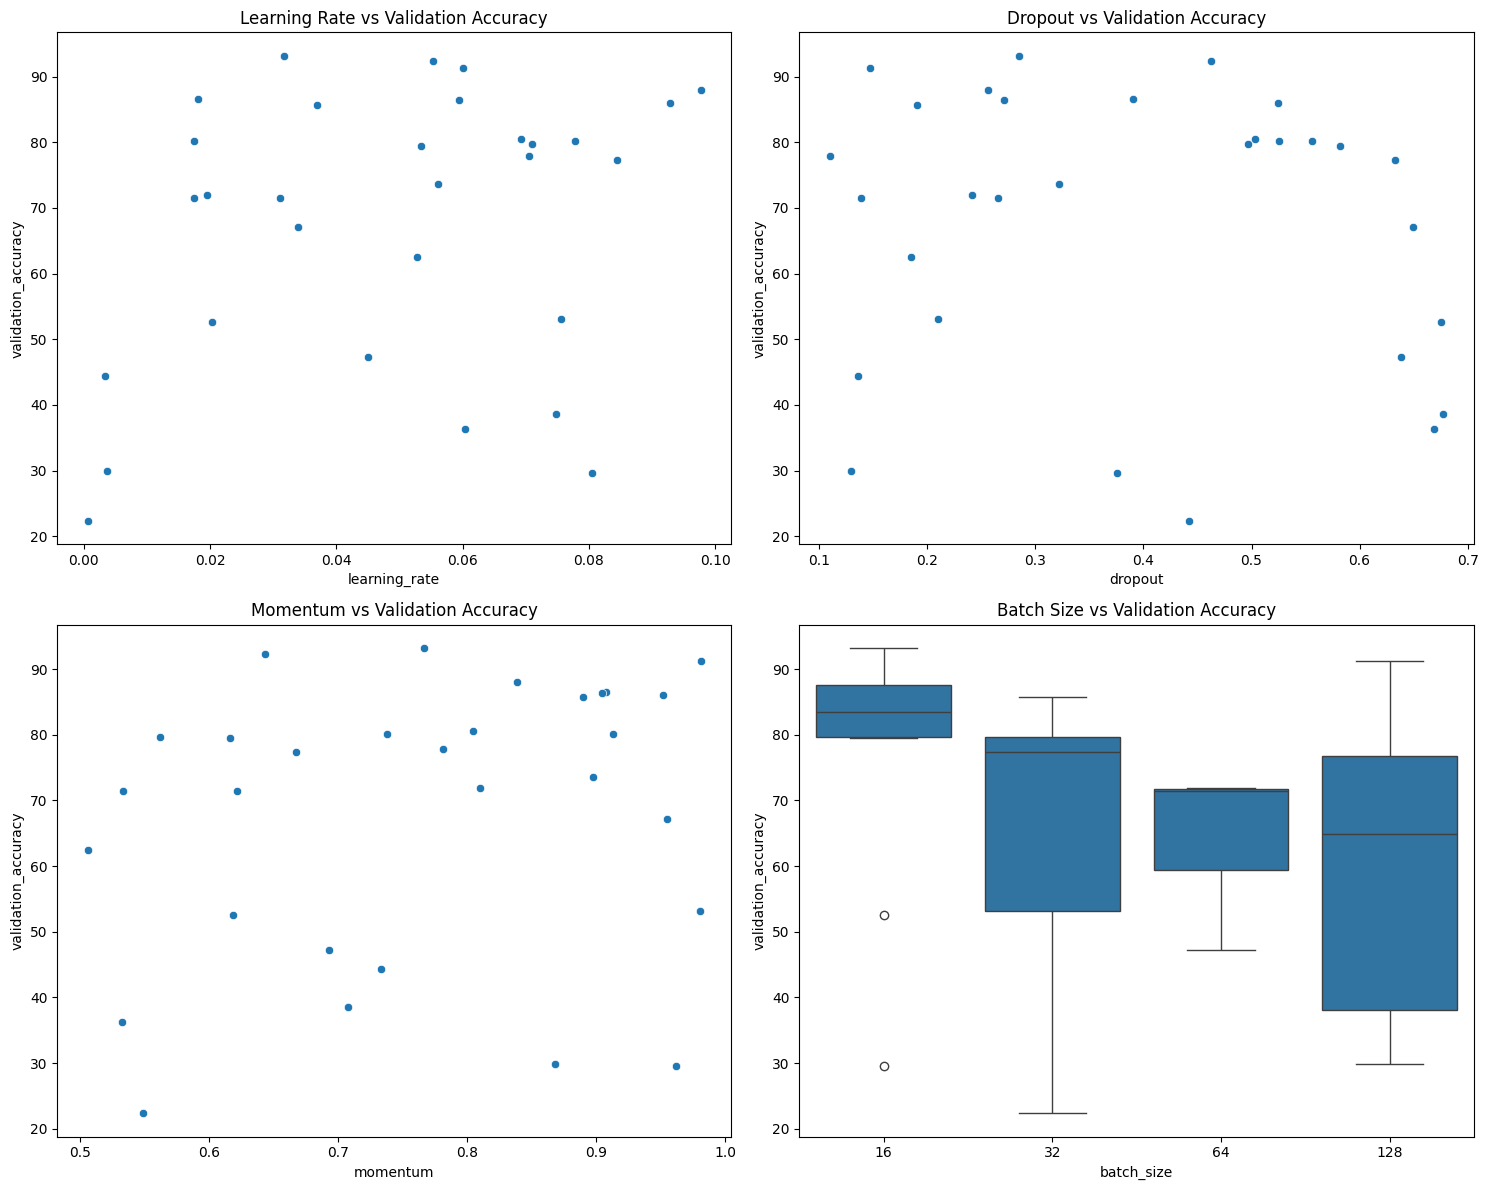

<ipython-input-43-ff93511d36dd>:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ax=axes[i], data=df[param], label="All Trials", shade=True)
<ipython-input-43-ff93511d36dd>:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ax=axes[i], data=top_20[param], label="Top 20% Best Trials", shade=True)
<ipython-input-43-ff93511d36dd>:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ax=axes[i], data=df[param], label="All Trials", shade=True)
<ipython-input-43-ff93511d36dd>:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code

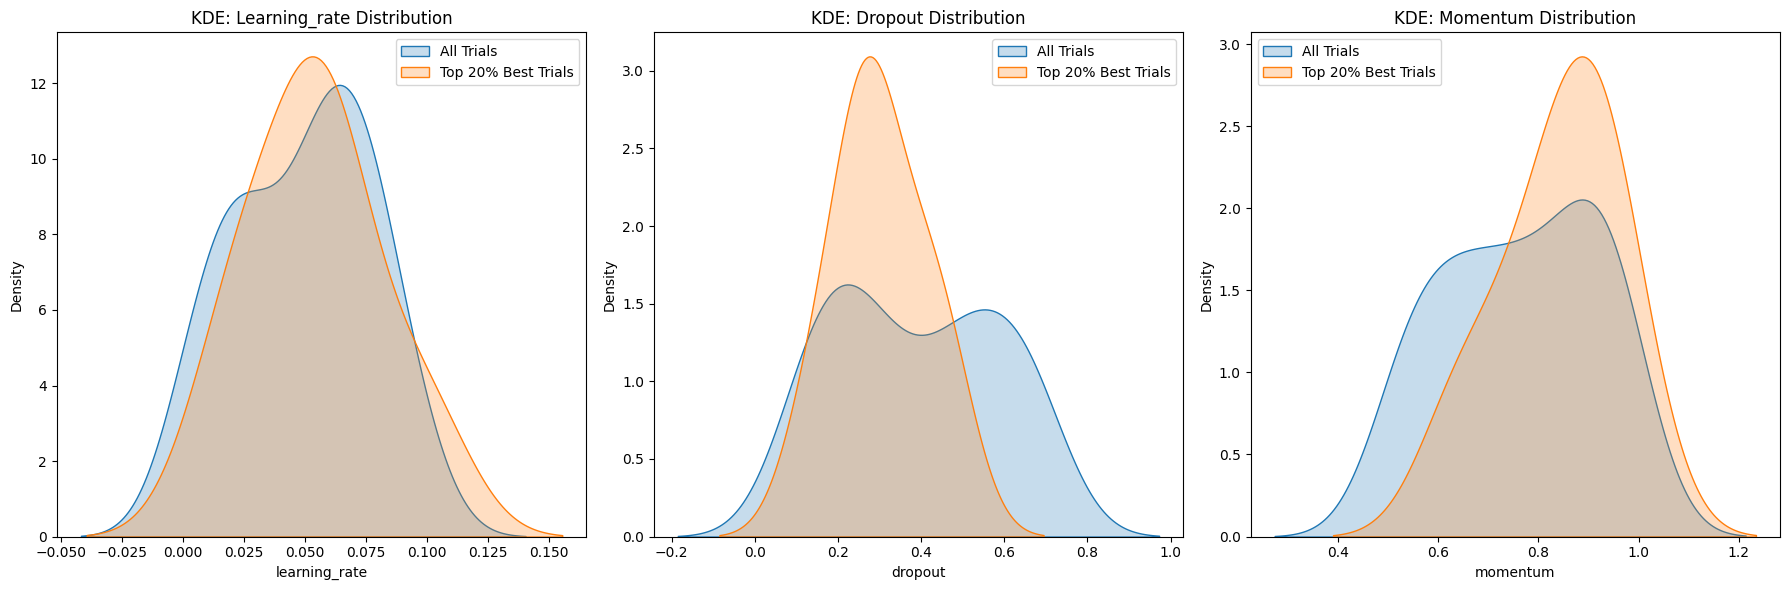

 KDE Statistics (coarse1_search_results.csv):
Learning_rate - Mean: 0.053731, Std Dev: 0.027457
Dropout - Mean: 0.302187, Std Dev: 0.110558
Momentum - Mean: 0.840436, Std Dev: 0.120737
Batch Size Counts (coarse1_search_results.csv):
batch_size
16     5
128    1
Name: count, dtype: int64
-----------------------Statistics for coarse2_search_results.csv:--------------------------------
Correlation with Validation Accuracy (coarse2_search_results.csv):
validation_accuracy    1.000000
batch_size             0.125034
learning_rate          0.094861
dropout                0.084970
trial                 -0.025474
momentum              -0.493561
model_type                  NaN
Name: validation_accuracy, dtype: float64


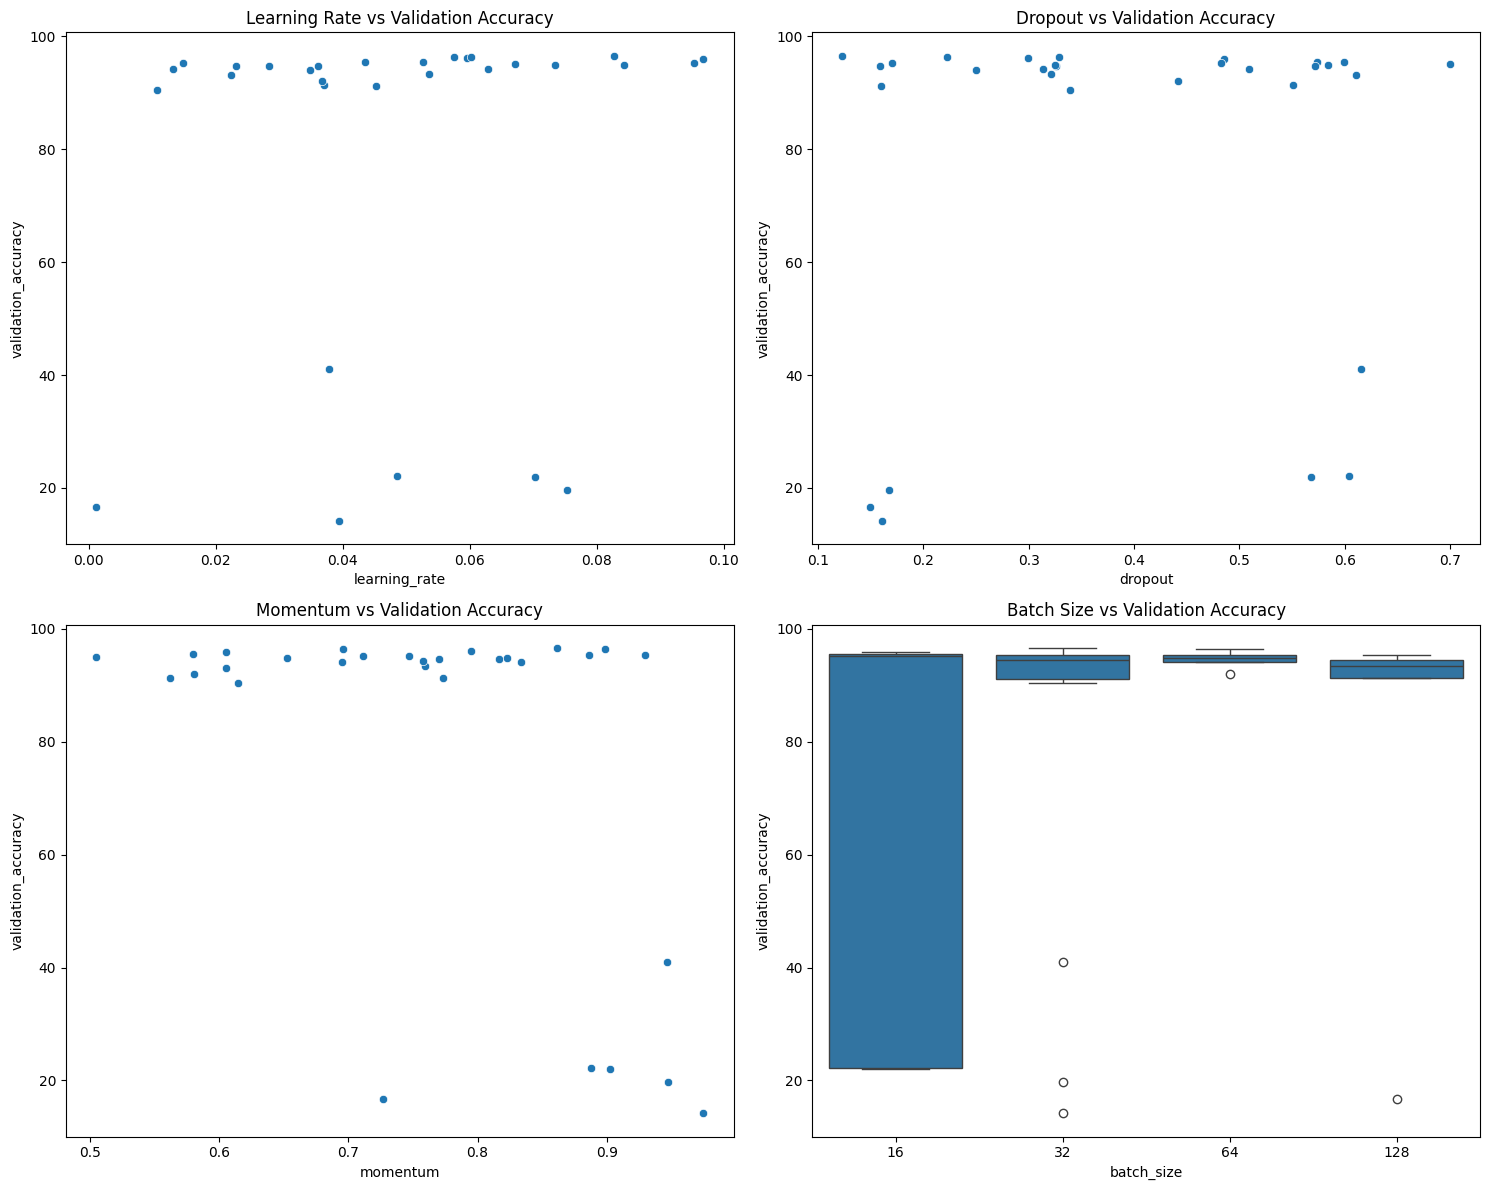

<ipython-input-43-ff93511d36dd>:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ax=axes[i], data=df[param], label="All Trials", shade=True)
<ipython-input-43-ff93511d36dd>:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ax=axes[i], data=top_20[param], label="Top 20% Best Trials", shade=True)
<ipython-input-43-ff93511d36dd>:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ax=axes[i], data=df[param], label="All Trials", shade=True)
<ipython-input-43-ff93511d36dd>:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code

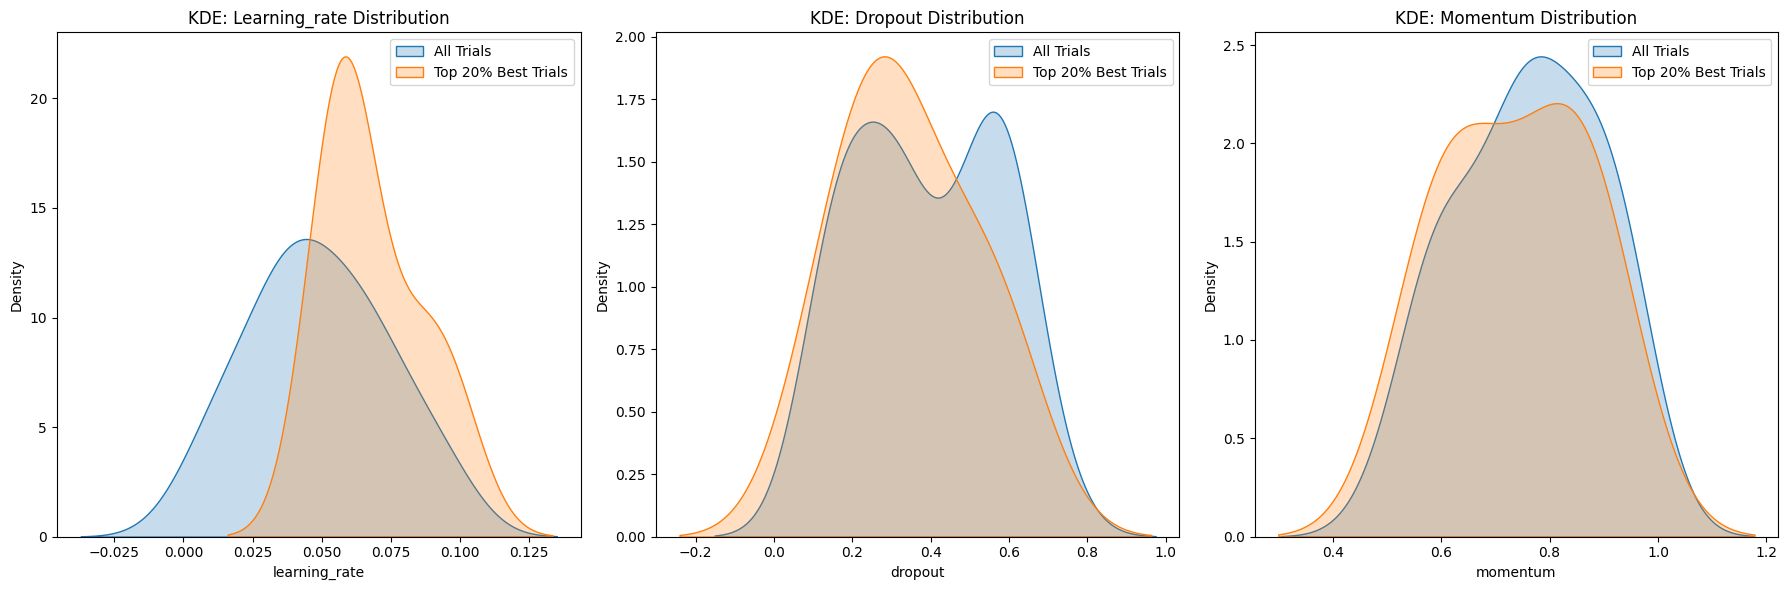

 KDE Statistics (coarse2_search_results.csv):
Learning_rate - Mean: 0.068225, Std Dev: 0.017446
Dropout - Mean: 0.343028, Std Dev: 0.173669
Momentum - Mean: 0.739255, Std Dev: 0.133335
Batch Size Counts (coarse2_search_results.csv):
batch_size
32    3
16    2
64    1
Name: count, dtype: int64
-----------------------Statistics for coarse3_search_results.csv:--------------------------------
Correlation with Validation Accuracy (coarse3_search_results.csv):
validation_accuracy    1.000000
batch_size             0.357856
dropout                0.070055
trial                  0.027782
learning_rate         -0.158727
momentum              -0.559410
model_type                  NaN
Name: validation_accuracy, dtype: float64


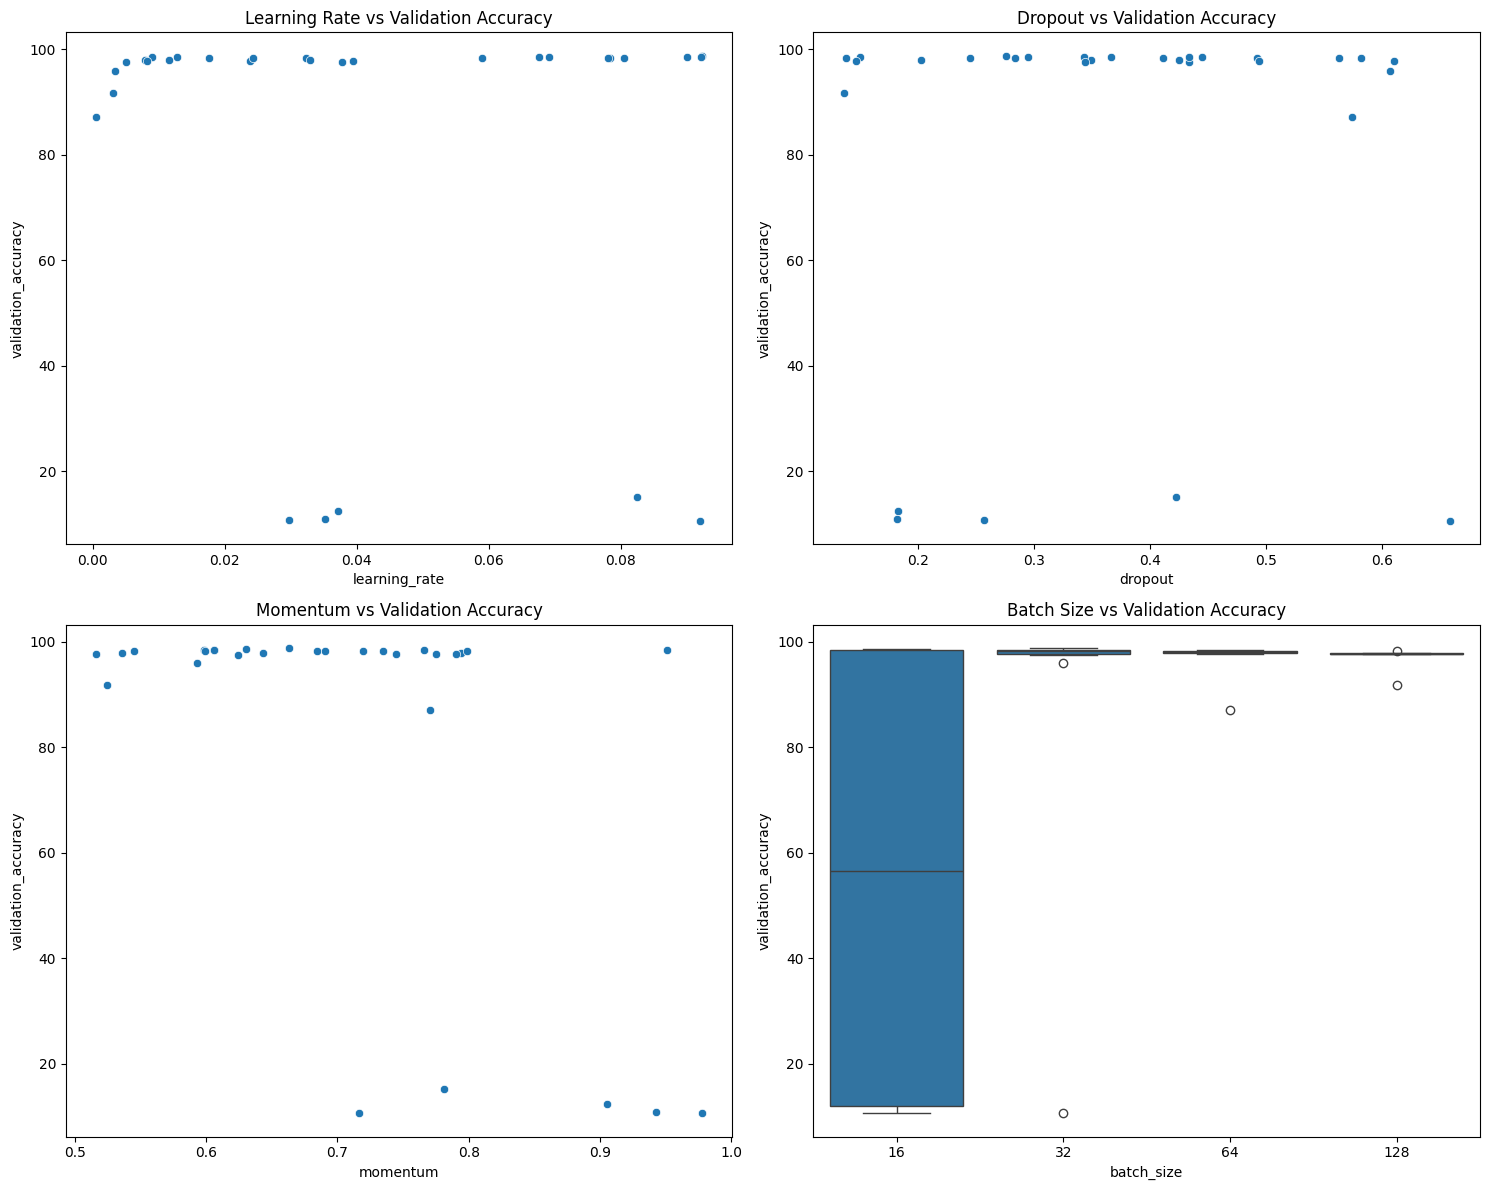

<ipython-input-43-ff93511d36dd>:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ax=axes[i], data=df[param], label="All Trials", shade=True)
<ipython-input-43-ff93511d36dd>:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ax=axes[i], data=top_20[param], label="Top 20% Best Trials", shade=True)
<ipython-input-43-ff93511d36dd>:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ax=axes[i], data=df[param], label="All Trials", shade=True)
<ipython-input-43-ff93511d36dd>:41: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code

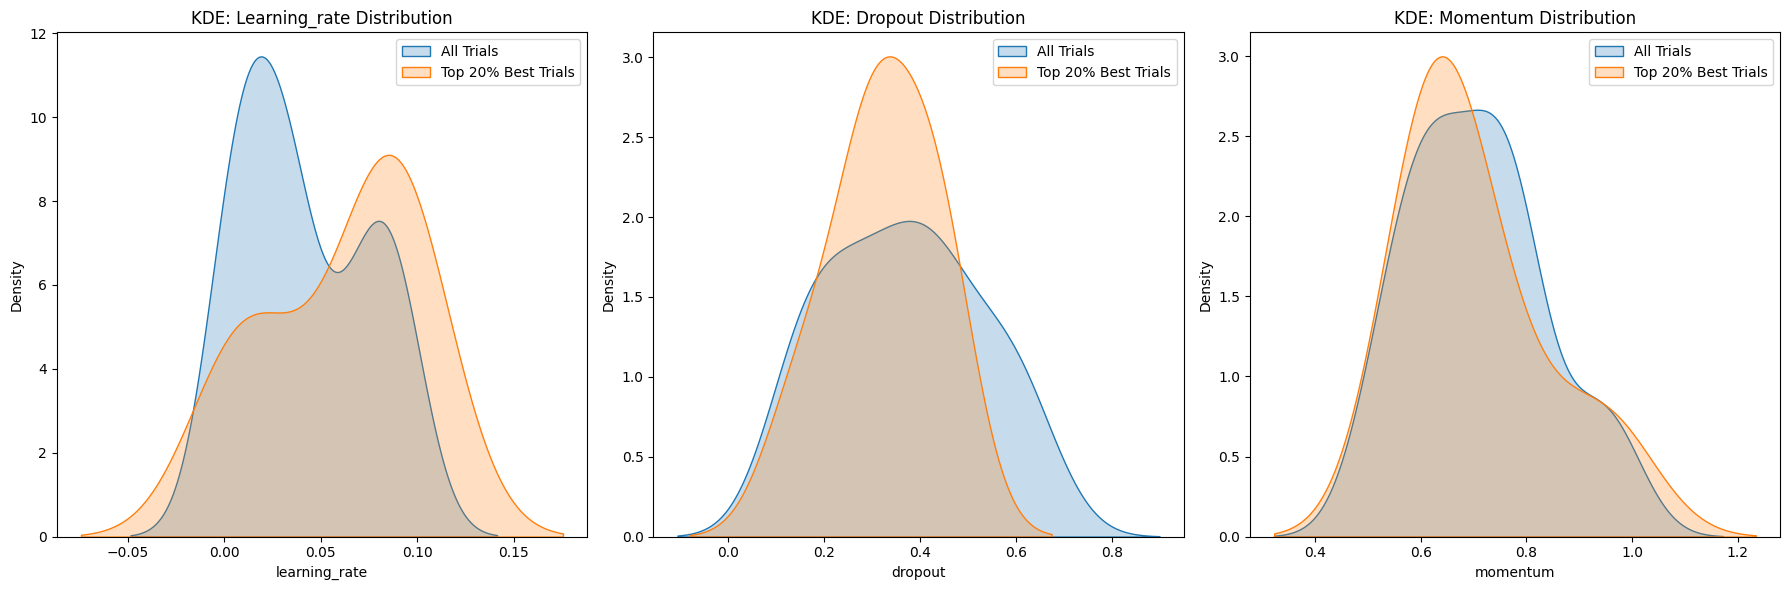

 KDE Statistics (coarse3_search_results.csv):
Learning_rate - Mean: 0.060648, Std Dev: 0.039675
Dropout - Mean: 0.323981, Std Dev: 0.109655
Momentum - Mean: 0.703704, Std Dev: 0.135024
Batch Size Counts (coarse3_search_results.csv):
batch_size
32    3
16    3
Name: count, dtype: int64


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_model_results(file_path):
    df = pd.read_csv(file_path)
    print(f"-----------------------Statistics for {file_path}:--------------------------------")

    cols = ["validation_accuracy", "learning_rate", "dropout", "momentum", "batch_size"]

    correlation_matrix = df.corr()
    print(f"Correlation with Validation Accuracy ({file_path}):")
    print(correlation_matrix["validation_accuracy"].sort_values(ascending=False))

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    sns.scatterplot(ax=axes[0, 0], x=df["learning_rate"], y=df["validation_accuracy"])
    axes[0, 0].set_title("Learning Rate vs Validation Accuracy")

    sns.scatterplot(ax=axes[0, 1], x=df["dropout"], y=df["validation_accuracy"])
    axes[0, 1].set_title("Dropout vs Validation Accuracy")

    sns.scatterplot(ax=axes[1, 0], x=df["momentum"], y=df["validation_accuracy"])
    axes[1, 0].set_title("Momentum vs Validation Accuracy")

    sns.boxplot(ax=axes[1, 1], x=df["batch_size"], y=df["validation_accuracy"])
    axes[1, 1].set_title("Batch Size vs Validation Accuracy")

    plt.tight_layout()
    plt.savefig(f"{file_path}_scatter_box_plots.png")
    plt.show()
    plt.close(fig)

    top_20 = df.nlargest(int(0.2 * len(df)), "validation_accuracy")
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, param in enumerate(["learning_rate", "dropout", "momentum"]):
        sns.kdeplot(ax=axes[i], data=df[param], label="All Trials", shade=True)
        sns.kdeplot(ax=axes[i], data=top_20[param], label="Top 20% Best Trials", shade=True)
        axes[i].set_title(f"KDE: {param.capitalize()} Distribution")
        axes[i].legend()

    plt.tight_layout()
    plt.savefig(f"{file_path}_kde_plots.png")
    plt.show()
    plt.close(fig)

    stats = {
        param: {
            "mean": top_20[param].mean(),
            "std": top_20[param].std()
        } for param in ["learning_rate", "dropout", "momentum"]
    }

    print(f" KDE Statistics ({file_path}):")
    for param, values in stats.items():
        print(f"{param.capitalize()} - Mean: {values['mean']:.6f}, Std Dev: {values['std']:.6f}")

    batchCounts = top_20["batch_size"].value_counts()

    print(f"Batch Size Counts ({file_path}):")
    print(batchCounts)

    return stats, batchCounts

model1_stats, model1_batchCounts = analyze_model_results("coarse1_search_results.csv")
model2_stats, model2_batchCounts = analyze_model_results("coarse2_search_results.csv")
model3_stats, model3_batchCounts = analyze_model_results("coarse3_search_results.csv")



# Fine Optimization with Bayesian
- Uses top 20% performing hyperparameter statistics.

In [ ]:
!pip install optuna


In [ ]:
import optuna

nTrials = 20

def objective(trial, modelType):
    if modelType == 1:
        stats = model1_stats
        batchCounts = model1_batchCounts
    elif modelType == 2:
        stats = model2_stats
        batchCounts = model2_batchCounts
    elif modelType == 3:
        stats = model3_stats
        batchCounts = model3_batchCounts

    if isinstance(batchCounts, pd.Series):
        batchCounts = batchCounts.to_dict()

    lr = trial.suggest_float('lr', stats["learning_rate"]["mean"] - stats["learning_rate"]["std"],
                                  stats["learning_rate"]["mean"] + stats["learning_rate"]["std"], log=False)
    mom = trial.suggest_float('momentum', stats["momentum"]["mean"] - stats["momentum"]["std"],
                                  stats["momentum"]["mean"] + stats["momentum"]["std"])
    dropout_p = trial.suggest_float('dropout_p', stats["dropout"]["mean"] - stats["dropout"]["std"],
                                  stats["dropout"]["mean"] + stats["dropout"]["std"])

    # Convert batch size frequencies to probabilities
    bs_options = list(batchCounts.keys())
    bs_probabilities = [batchCounts[bs] / sum(batchCounts.values()) for bs in bs_options]
    bs = int(np.random.choice(bs_options, p=bs_probabilities))

    trainLoader = DataLoader(trainingSet, batch_size=bs, shuffle=True)
    valLoader = DataLoader(validationSet, batch_size=bs, shuffle=False)

    if modelType ==1:
        W1, b1, W2, b2, W3, b3, W4, b4 = InitializeWeights('effective', modelType)
        trained_parameters, _ = TrainModel(W1, b1, W2, b2, W3, b3, W4, b4, lr, mom, bs, trainLoader, dropout_p, modelType)
        validation_accuracy = ValidateModel(*trained_parameters, valLoader, dropout_p, modelType)

        if trial.number == 0 or validation_accuracy > trial.study.best_trial.value:
            torch.save({'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3, 'W4': W4, 'b4': b4, 'batch_size': bs}, f'best_model_{modelType}.pth')

    elif modelType == 2:
        model = LocallyConnectedNN(initials='effective', dropout_p=dropout_p)
        trained_model, _, _ = train_LCNN(model, lr, mom, trainLoader)
        validation_accuracy = ValidateLCNN(trained_model, valLoader)

        if trial.number == 0 or validation_accuracy > trial.study.best_trial.value:
            torch.save({'model_state': trained_model.state_dict(), 'batch_size': bs}, f'best_model_{modelType}.pth')

    elif modelType == 3:
        model = CNNModel(initials='effective', dropout_p=dropout_p)
        trained_model, _, _ = TrainCNN(model, lr, mom, trainLoader)
        validation_accuracy = ValidateCNN(trained_model, valLoader)

        if trial.number == 0 or validation_accuracy > trial.study.best_trial.value:
            torch.save({'model_state': trained_model.state_dict(), 'batch_size': bs}, f'best_model_{modelType}.pth')

    return validation_accuracy

# Optimize and validate
print("----- Fine Tuning Model 1 with Optuna-----")
study1 = optuna.create_study(direction='maximize')
study1.optimize(lambda trial: objective(trial, modelType=1), n_trials=nTrials)

print(" Best Hyperparameters for Model 1:")
print(study1.best_params)
print(f"Best Validation Accuracy: {study1.best_value:.6f}")

print("----- Fine Tuning Model 2 with Optuna-----")
study2 = optuna.create_study(direction='maximize')
study2.optimize(lambda trial: objective(trial, modelType=2), n_trials=nTrials)

print("Best Hyperparameters for Model 2:")
print(study2.best_params)
print(f"Best Validation Accuracy: {study2.best_value:.6f}")

print("----- Fine Tuning Model 3 with Optuna-----")
study3 = optuna.create_study(direction='maximize')
study3.optimize(lambda trial: objective(trial, modelType=3), n_trials=nTrials)

print("Best Hyperparameters for Model 3:")
print(study3.best_params)
print(f"Best Validation Accuracy: {study3.best_value:.6f}")



[I 2025-03-19 18:31:19,660] A new study created in memory with name: no-name-bed3ccd9-ff1c-4e18-aaae-b4ffbc2d5104


----- Fine Tuning Model 1 with Optuna-----
Epoch 5/20, Loss: 611.540969
Epoch 10/20, Loss: 602.067193
Epoch 15/20, Loss: 581.717035


[I 2025-03-19 18:31:34,199] Trial 0 finished with value: 86.77176148046607 and parameters: {'lr': 0.034047579071626366, 'momentum': 0.8874615706449955, 'dropout_p': 0.23482818481517878}. Best is trial 0 with value: 86.77176148046607.


Epoch 20/20, Loss: 578.023225
Epoch 5/20, Loss: 620.659777
Epoch 10/20, Loss: 609.405911
Epoch 15/20, Loss: 605.977287


[I 2025-03-19 18:31:48,770] Trial 1 finished with value: 80.67169294037012 and parameters: {'lr': 0.05478965127419728, 'momentum': 0.8831519554617032, 'dropout_p': 0.41065934441392465}. Best is trial 0 with value: 86.77176148046607.


Epoch 20/20, Loss: 603.348539
Epoch 5/20, Loss: 594.791162
Epoch 10/20, Loss: 586.745618
Epoch 15/20, Loss: 582.404783


[I 2025-03-19 18:32:03,011] Trial 2 finished with value: 86.56614119259767 and parameters: {'lr': 0.051421090839922655, 'momentum': 0.9334698287809677, 'dropout_p': 0.2839791382272374}. Best is trial 0 with value: 86.77176148046607.


Epoch 20/20, Loss: 578.713136
Epoch 5/20, Loss: 607.120471
Epoch 10/20, Loss: 586.000876
Epoch 15/20, Loss: 578.135461


[I 2025-03-19 18:32:16,152] Trial 3 finished with value: 92.46058944482522 and parameters: {'lr': 0.06013575248792161, 'momentum': 0.8838293699441343, 'dropout_p': 0.299137593876831}. Best is trial 3 with value: 92.46058944482522.


Epoch 20/20, Loss: 569.089773
Epoch 5/20, Loss: 629.596441
Epoch 10/20, Loss: 616.613641
Epoch 15/20, Loss: 611.957363


[I 2025-03-19 18:32:29,356] Trial 4 finished with value: 77.8615490061686 and parameters: {'lr': 0.05529980175369678, 'momentum': 0.7298166472482941, 'dropout_p': 0.30018484711021226}. Best is trial 3 with value: 92.46058944482522.


Epoch 20/20, Loss: 608.915843
Epoch 5/20, Loss: 95.262050
Epoch 10/20, Loss: 88.545516
Epoch 15/20, Loss: 83.547182


[I 2025-03-19 18:32:32,646] Trial 5 finished with value: 79.36943111720356 and parameters: {'lr': 0.028941561481340902, 'momentum': 0.8968206300721496, 'dropout_p': 0.3165324119707989}. Best is trial 3 with value: 92.46058944482522.


Epoch 20/20, Loss: 78.767781
Epoch 5/20, Loss: 660.939441
Epoch 10/20, Loss: 615.497773
Epoch 15/20, Loss: 589.046005


[I 2025-03-19 18:32:46,603] Trial 6 finished with value: 87.38862234407128 and parameters: {'lr': 0.03526618868877335, 'momentum': 0.7639780194607725, 'dropout_p': 0.39365940039919445}. Best is trial 3 with value: 92.46058944482522.


Epoch 20/20, Loss: 583.566308
Epoch 5/20, Loss: 628.151063
Epoch 10/20, Loss: 611.280380
Epoch 15/20, Loss: 608.188449


[I 2025-03-19 18:32:59,781] Trial 7 finished with value: 78.75257025359835 and parameters: {'lr': 0.07283179304973796, 'momentum': 0.7265129758055199, 'dropout_p': 0.32595107807393786}. Best is trial 3 with value: 92.46058944482522.


Epoch 20/20, Loss: 606.336966
Epoch 5/20, Loss: 608.726192
Epoch 10/20, Loss: 604.389093
Epoch 15/20, Loss: 580.616726


[I 2025-03-19 18:33:13,618] Trial 8 finished with value: 86.29198080877313 and parameters: {'lr': 0.06791302975101147, 'momentum': 0.8552223887223174, 'dropout_p': 0.19382280084561296}. Best is trial 3 with value: 92.46058944482522.


Epoch 20/20, Loss: 580.446829
Epoch 5/20, Loss: 603.750165
Epoch 10/20, Loss: 595.525549
Epoch 15/20, Loss: 594.248310


[I 2025-03-19 18:33:27,789] Trial 9 finished with value: 85.26387936943112 and parameters: {'lr': 0.053632918102031205, 'momentum': 0.9456510868159185, 'dropout_p': 0.3175224172162354}. Best is trial 3 with value: 92.46058944482522.


Epoch 20/20, Loss: 596.366959
Epoch 5/20, Loss: 92.014063
Epoch 10/20, Loss: 82.297371
Epoch 15/20, Loss: 77.600753


[I 2025-03-19 18:33:31,949] Trial 10 finished with value: 90.54146675805346 and parameters: {'lr': 0.07796425349175035, 'momentum': 0.8004404605871385, 'dropout_p': 0.3651205059285633}. Best is trial 3 with value: 92.46058944482522.


Epoch 20/20, Loss: 74.936287
Epoch 5/20, Loss: 600.587944
Epoch 10/20, Loss: 586.795553
Epoch 15/20, Loss: 585.866640


[I 2025-03-19 18:33:45,138] Trial 11 finished with value: 87.66278272789582 and parameters: {'lr': 0.07999175520408072, 'momentum': 0.8090258308577305, 'dropout_p': 0.3640371339698381}. Best is trial 3 with value: 92.46058944482522.


Epoch 20/20, Loss: 577.845667
Epoch 5/20, Loss: 606.904108
Epoch 10/20, Loss: 569.468766
Epoch 15/20, Loss: 563.452189


[I 2025-03-19 18:33:58,213] Trial 12 finished with value: 92.80328992460589 and parameters: {'lr': 0.06501621616475017, 'momentum': 0.8102468878123883, 'dropout_p': 0.3582425771451892}. Best is trial 12 with value: 92.80328992460589.


Epoch 20/20, Loss: 561.767186
Epoch 5/20, Loss: 606.476105
Epoch 10/20, Loss: 579.177542
Epoch 15/20, Loss: 557.081227


[I 2025-03-19 18:34:11,331] Trial 13 finished with value: 94.44825222755311 and parameters: {'lr': 0.06430407551017912, 'momentum': 0.8320787206655826, 'dropout_p': 0.26496862244067554}. Best is trial 13 with value: 94.44825222755311.


Epoch 20/20, Loss: 553.044889
Epoch 5/20, Loss: 585.449670
Epoch 10/20, Loss: 572.148151
Epoch 15/20, Loss: 553.155831


[I 2025-03-19 18:34:25,772] Trial 14 finished with value: 93.6257710760795 and parameters: {'lr': 0.06600603022675217, 'momentum': 0.8233409577465443, 'dropout_p': 0.25924944926813015}. Best is trial 13 with value: 94.44825222755311.


Epoch 20/20, Loss: 552.893969
Epoch 5/20, Loss: 95.261878
Epoch 10/20, Loss: 90.422364
Epoch 15/20, Loss: 85.721226


[I 2025-03-19 18:34:28,991] Trial 15 finished with value: 71.48732008224812 and parameters: {'lr': 0.04357639473730135, 'momentum': 0.8319472519383208, 'dropout_p': 0.2585429896540758}. Best is trial 13 with value: 94.44825222755311.


Epoch 20/20, Loss: 82.722301
Epoch 5/20, Loss: 611.826719
Epoch 10/20, Loss: 606.032800
Epoch 15/20, Loss: 600.638489


[I 2025-03-19 18:34:43,282] Trial 16 finished with value: 87.38862234407128 and parameters: {'lr': 0.06759860109272803, 'momentum': 0.7625541739739721, 'dropout_p': 0.23507912965788832}. Best is trial 13 with value: 94.44825222755311.


Epoch 20/20, Loss: 580.082616
Epoch 5/20, Loss: 585.764782
Epoch 10/20, Loss: 577.254215
Epoch 15/20, Loss: 574.640277


[I 2025-03-19 18:34:56,381] Trial 17 finished with value: 92.73474982864975 and parameters: {'lr': 0.0467724658994783, 'momentum': 0.856289744066962, 'dropout_p': 0.26352042314401747}. Best is trial 13 with value: 94.44825222755311.


Epoch 20/20, Loss: 567.558366
Epoch 5/20, Loss: 591.736357
Epoch 10/20, Loss: 575.448685
Epoch 15/20, Loss: 571.460395


[I 2025-03-19 18:35:14,098] Trial 18 finished with value: 88.00548320767649 and parameters: {'lr': 0.06071409659524889, 'momentum': 0.7723669167400313, 'dropout_p': 0.20226960462828955}. Best is trial 13 with value: 94.44825222755311.


Epoch 20/20, Loss: 569.564322
Epoch 5/20, Loss: 88.628855
Epoch 10/20, Loss: 79.489063
Epoch 15/20, Loss: 75.293416


[I 2025-03-19 18:35:17,913] Trial 19 finished with value: 91.08978752570253 and parameters: {'lr': 0.07357862384248669, 'momentum': 0.8334613962348978, 'dropout_p': 0.226221710099366}. Best is trial 13 with value: 94.44825222755311.
[I 2025-03-19 18:35:17,915] A new study created in memory with name: no-name-36b08a04-b5ec-4e9a-a73e-49303535eeba


Epoch 20/20, Loss: 72.476352
 Best Hyperparameters for Model 1:
{'lr': 0.06430407551017912, 'momentum': 0.8320787206655826, 'dropout_p': 0.26496862244067554}
Best Validation Accuracy: 94.448252
----- Fine Tuning Model 2 with Optuna-----
Epoch 5/20, Loss: 64.146863
Epoch 10/20, Loss: 29.848542
Epoch 15/20, Loss: 20.156570
Epoch 20/20, Loss: 9.757737


[I 2025-03-19 18:36:40,463] Trial 0 finished with value: 96.02467443454421 and parameters: {'lr': 0.05614978262308136, 'momentum': 0.6429190672481764, 'dropout_p': 0.3567288853650352}. Best is trial 0 with value: 96.02467443454421.


Epoch 5/20, Loss: 68.794641
Epoch 10/20, Loss: 28.920128
Epoch 15/20, Loss: 21.461171
Epoch 20/20, Loss: 10.579331


[I 2025-03-19 18:38:03,719] Trial 1 finished with value: 95.33927347498286 and parameters: {'lr': 0.06662858831858116, 'momentum': 0.6434381080098407, 'dropout_p': 0.4070246604414147}. Best is trial 0 with value: 96.02467443454421.


Epoch 5/20, Loss: 34.607722
Epoch 10/20, Loss: 19.008798
Epoch 15/20, Loss: 11.621681
Epoch 20/20, Loss: 6.799508


[I 2025-03-19 18:39:18,226] Trial 2 finished with value: 95.407813570939 and parameters: {'lr': 0.07554999775346918, 'momentum': 0.6400130012350709, 'dropout_p': 0.2936978573734331}. Best is trial 0 with value: 96.02467443454421.


Epoch 5/20, Loss: 60.117431
Epoch 10/20, Loss: 32.217164
Epoch 15/20, Loss: 22.721992
Epoch 20/20, Loss: 10.128489


[I 2025-03-19 18:40:41,798] Trial 3 finished with value: 96.02467443454421 and parameters: {'lr': 0.05768150882664688, 'momentum': 0.7199454127684649, 'dropout_p': 0.37679764569078283}. Best is trial 0 with value: 96.02467443454421.


Epoch 5/20, Loss: 59.546281
Epoch 10/20, Loss: 37.701169
Epoch 15/20, Loss: 33.444853
Epoch 20/20, Loss: 34.200788


[I 2025-03-19 18:42:07,013] Trial 4 finished with value: 94.37971213159699 and parameters: {'lr': 0.05865142616230369, 'momentum': 0.8459237092410179, 'dropout_p': 0.4059002576278006}. Best is trial 0 with value: 96.02467443454421.


Epoch 5/20, Loss: 19.173252
Epoch 10/20, Loss: 9.302632
Epoch 15/20, Loss: 5.472466
Epoch 20/20, Loss: 3.405353


[I 2025-03-19 18:43:18,059] Trial 5 finished with value: 96.23029472241261 and parameters: {'lr': 0.07355909825961532, 'momentum': 0.8337825824590059, 'dropout_p': 0.25413367107462853}. Best is trial 5 with value: 96.23029472241261.


Epoch 5/20, Loss: 22.077762
Epoch 10/20, Loss: 12.639167
Epoch 15/20, Loss: 7.623877
Epoch 20/20, Loss: 4.874378


[I 2025-03-19 18:44:29,621] Trial 6 finished with value: 95.88759424263193 and parameters: {'lr': 0.07771889254872497, 'momentum': 0.7278316528726531, 'dropout_p': 0.25235511471764105}. Best is trial 5 with value: 96.23029472241261.


Epoch 5/20, Loss: 46.130959
Epoch 10/20, Loss: 26.320434
Epoch 15/20, Loss: 16.844511
Epoch 20/20, Loss: 12.370133


[I 2025-03-19 18:45:42,883] Trial 7 finished with value: 95.13365318711446 and parameters: {'lr': 0.05420984941802668, 'momentum': 0.6226192947865411, 'dropout_p': 0.3713631179399439}. Best is trial 5 with value: 96.23029472241261.


Epoch 5/20, Loss: 36.620801
Epoch 10/20, Loss: 19.819751
Epoch 15/20, Loss: 13.922845
Epoch 20/20, Loss: 10.401551


[I 2025-03-19 18:46:52,462] Trial 8 finished with value: 94.72241261137765 and parameters: {'lr': 0.06506821450168414, 'momentum': 0.6062031836580504, 'dropout_p': 0.4466841434308998}. Best is trial 5 with value: 96.23029472241261.


Epoch 5/20, Loss: 22.734003
Epoch 10/20, Loss: 13.471588
Epoch 15/20, Loss: 9.435161
Epoch 20/20, Loss: 5.028962


[I 2025-03-19 18:48:02,701] Trial 9 finished with value: 95.47635366689514 and parameters: {'lr': 0.07634976101557073, 'momentum': 0.7679929728420489, 'dropout_p': 0.38207625530003303}. Best is trial 5 with value: 96.23029472241261.


Epoch 5/20, Loss: 163.411717
Epoch 10/20, Loss: 1668.218970
Epoch 15/20, Loss: 1591.640610
Epoch 20/20, Loss: 1631.146331


[I 2025-03-19 18:49:28,299] Trial 10 finished with value: 23.646333104866347 and parameters: {'lr': 0.08346528106024734, 'momentum': 0.8724936379285653, 'dropout_p': 0.18575399717251342}. Best is trial 5 with value: 96.23029472241261.


Epoch 5/20, Loss: 30.710352
Epoch 10/20, Loss: 15.373518
Epoch 15/20, Loss: 9.891833
Epoch 20/20, Loss: 5.724034


[I 2025-03-19 18:50:50,982] Trial 11 finished with value: 95.81905414667581 and parameters: {'lr': 0.07124233321350036, 'momentum': 0.7993080739166182, 'dropout_p': 0.5101331618469335}. Best is trial 5 with value: 96.23029472241261.


Epoch 5/20, Loss: 39.849784
Epoch 10/20, Loss: 19.677176
Epoch 15/20, Loss: 11.622852
Epoch 20/20, Loss: 6.335258


[I 2025-03-19 18:52:05,389] Trial 12 finished with value: 96.16175462645647 and parameters: {'lr': 0.060594329318844196, 'momentum': 0.6882070770891007, 'dropout_p': 0.29650756152031393}. Best is trial 5 with value: 96.23029472241261.


Epoch 5/20, Loss: 38.412153
Epoch 10/20, Loss: 17.300976
Epoch 15/20, Loss: 7.992735
Epoch 20/20, Loss: 5.667710


[I 2025-03-19 18:53:19,317] Trial 13 finished with value: 95.407813570939 and parameters: {'lr': 0.06311747486118968, 'momentum': 0.6911094312587963, 'dropout_p': 0.2822999102544067}. Best is trial 5 with value: 96.23029472241261.


Epoch 5/20, Loss: 31.415204
Epoch 10/20, Loss: 15.116328
Epoch 15/20, Loss: 8.853486
Epoch 20/20, Loss: 4.263672


[I 2025-03-19 18:54:32,784] Trial 14 finished with value: 96.02467443454421 and parameters: {'lr': 0.0511265082557252, 'momentum': 0.8058212455541646, 'dropout_p': 0.20621131397681963}. Best is trial 5 with value: 96.23029472241261.


Epoch 5/20, Loss: 54.673046
Epoch 10/20, Loss: 27.018284
Epoch 15/20, Loss: 16.838609
Epoch 20/20, Loss: 6.766117


[I 2025-03-19 18:56:02,456] Trial 15 finished with value: 95.88759424263193 and parameters: {'lr': 0.061422175004252524, 'momentum': 0.6879129066131962, 'dropout_p': 0.31356091255581975}. Best is trial 5 with value: 96.23029472241261.


Epoch 5/20, Loss: 30.681887
Epoch 10/20, Loss: 13.810056
Epoch 15/20, Loss: 6.722936
Epoch 20/20, Loss: 3.410373


[I 2025-03-19 18:57:14,567] Trial 16 finished with value: 95.95613433858807 and parameters: {'lr': 0.07029026546565918, 'momentum': 0.7629263012064458, 'dropout_p': 0.24835830368020484}. Best is trial 5 with value: 96.23029472241261.


Epoch 5/20, Loss: 33.851095
Epoch 10/20, Loss: 16.933899
Epoch 15/20, Loss: 8.673573
Epoch 20/20, Loss: 4.951734


[I 2025-03-19 18:58:26,502] Trial 17 finished with value: 96.23029472241261 and parameters: {'lr': 0.08422348240653685, 'momentum': 0.6786076430742957, 'dropout_p': 0.23567197389007727}. Best is trial 5 with value: 96.23029472241261.


Epoch 5/20, Loss: 24.360371
Epoch 10/20, Loss: 10.459217
Epoch 15/20, Loss: 3.297621
Epoch 20/20, Loss: 1.660364


[I 2025-03-19 18:59:39,803] Trial 18 finished with value: 95.68197395476354 and parameters: {'lr': 0.08550357925569235, 'momentum': 0.826981271325786, 'dropout_p': 0.2188100523858499}. Best is trial 5 with value: 96.23029472241261.


Epoch 5/20, Loss: 20.016153
Epoch 10/20, Loss: 10.326087
Epoch 15/20, Loss: 6.743942
Epoch 20/20, Loss: 4.201515


[I 2025-03-19 19:00:49,977] Trial 19 finished with value: 95.47635366689514 and parameters: {'lr': 0.07914011220824642, 'momentum': 0.7766443053886533, 'dropout_p': 0.24372152940092953}. Best is trial 5 with value: 96.23029472241261.
[I 2025-03-19 19:00:49,978] A new study created in memory with name: no-name-caf88d28-a6bd-4b66-b9d8-1b09e27cb515


Best Hyperparameters for Model 2:
{'lr': 0.07355909825961532, 'momentum': 0.8337825824590059, 'dropout_p': 0.25413367107462853}
Best Validation Accuracy: 96.230295
----- Fine Tuning Model 3 with Optuna-----
Epoch 5/20, Loss: 7.656994
Epoch 10/20, Loss: 2.283786
Epoch 15/20, Loss: 0.689538
Epoch 20/20, Loss: 0.820934


[I 2025-03-19 19:01:59,447] Trial 0 finished with value: 98.56065798492118 and parameters: {'lr': 0.050514338871475814, 'momentum': 0.815561791367673, 'dropout_p': 0.24621060807502507}. Best is trial 0 with value: 98.56065798492118.


Epoch 5/20, Loss: 4.311466
Epoch 10/20, Loss: 1.060102
Epoch 15/20, Loss: 0.764987
Epoch 20/20, Loss: 0.493252


[I 2025-03-19 19:02:56,070] Trial 1 finished with value: 98.42357779300892 and parameters: {'lr': 0.04383195233326463, 'momentum': 0.7193240309366717, 'dropout_p': 0.23646965469465178}. Best is trial 0 with value: 98.56065798492118.


Epoch 5/20, Loss: 4.129270
Epoch 10/20, Loss: 1.173029
Epoch 15/20, Loss: 0.443934
Epoch 20/20, Loss: 0.169383


[I 2025-03-19 19:03:52,216] Trial 2 finished with value: 98.56065798492118 and parameters: {'lr': 0.08749950254990294, 'momentum': 0.7703251572428097, 'dropout_p': 0.3377269853376296}. Best is trial 0 with value: 98.56065798492118.


Epoch 5/20, Loss: 7.088130
Epoch 10/20, Loss: 2.579103
Epoch 15/20, Loss: 0.922760
Epoch 20/20, Loss: 0.647338


[I 2025-03-19 19:05:02,837] Trial 3 finished with value: 97.94379712131597 and parameters: {'lr': 0.028535134789711796, 'momentum': 0.701422064568646, 'dropout_p': 0.2451294388589284}. Best is trial 0 with value: 98.56065798492118.


Epoch 5/20, Loss: 7.054409
Epoch 10/20, Loss: 2.152424
Epoch 15/20, Loss: 1.038256
Epoch 20/20, Loss: 0.731273


[I 2025-03-19 19:06:00,507] Trial 4 finished with value: 98.69773817683345 and parameters: {'lr': 0.031456655187584004, 'momentum': 0.6667243871577918, 'dropout_p': 0.23087553477667255}. Best is trial 4 with value: 98.69773817683345.


Epoch 5/20, Loss: 7.522471
Epoch 10/20, Loss: 2.188819
Epoch 15/20, Loss: 1.179118
Epoch 20/20, Loss: 0.745950


[I 2025-03-19 19:06:57,363] Trial 5 finished with value: 98.42357779300892 and parameters: {'lr': 0.032651391710719305, 'momentum': 0.6418052556846685, 'dropout_p': 0.2692693432244261}. Best is trial 4 with value: 98.69773817683345.


Epoch 5/20, Loss: 8.277506
Epoch 10/20, Loss: 3.322373
Epoch 15/20, Loss: 1.125226
Epoch 20/20, Loss: 0.751468


[I 2025-03-19 19:08:07,361] Trial 6 finished with value: 98.08087731322824 and parameters: {'lr': 0.03727075088635426, 'momentum': 0.5715659220687922, 'dropout_p': 0.31255737555624163}. Best is trial 4 with value: 98.69773817683345.


Epoch 5/20, Loss: 6.341991
Epoch 10/20, Loss: 2.591760
Epoch 15/20, Loss: 1.521084
Epoch 20/20, Loss: 1.421041


[I 2025-03-19 19:09:03,939] Trial 7 finished with value: 98.28649760109664 and parameters: {'lr': 0.07898246009759233, 'momentum': 0.8322050228203155, 'dropout_p': 0.4123520852153}. Best is trial 4 with value: 98.69773817683345.


Epoch 5/20, Loss: 4.252191
Epoch 10/20, Loss: 1.385552
Epoch 15/20, Loss: 0.611116
Epoch 20/20, Loss: 0.423886


[I 2025-03-19 19:10:00,085] Trial 8 finished with value: 98.42357779300892 and parameters: {'lr': 0.04931574760336117, 'momentum': 0.761253860283678, 'dropout_p': 0.3279881970267983}. Best is trial 4 with value: 98.69773817683345.


Epoch 5/20, Loss: 9.872767
Epoch 10/20, Loss: 4.641131
Epoch 15/20, Loss: 1.999860
Epoch 20/20, Loss: 0.712671


[I 2025-03-19 19:11:10,215] Trial 9 finished with value: 98.62919808087732 and parameters: {'lr': 0.042445975397605265, 'momentum': 0.838264068310872, 'dropout_p': 0.34834869055516265}. Best is trial 4 with value: 98.69773817683345.


Epoch 5/20, Loss: 3.341238
Epoch 10/20, Loss: 0.854286
Epoch 15/20, Loss: 0.522927
Epoch 20/20, Loss: 0.357332


[I 2025-03-19 19:12:06,798] Trial 10 finished with value: 98.49211788896504 and parameters: {'lr': 0.06934970228116245, 'momentum': 0.632193333111344, 'dropout_p': 0.21607729775077}. Best is trial 4 with value: 98.69773817683345.


Epoch 5/20, Loss: 11.392866
Epoch 10/20, Loss: 3.028203
Epoch 15/20, Loss: 2.447826
Epoch 20/20, Loss: 1.846351


[I 2025-03-19 19:13:19,109] Trial 11 finished with value: 98.56065798492118 and parameters: {'lr': 0.023038617617581397, 'momentum': 0.6733026056422938, 'dropout_p': 0.3832639014593311}. Best is trial 4 with value: 98.69773817683345.


Epoch 5/20, Loss: 4.705569
Epoch 10/20, Loss: 1.555093
Epoch 15/20, Loss: 0.856891
Epoch 20/20, Loss: 0.589403


[I 2025-03-19 19:14:14,914] Trial 12 finished with value: 98.35503769705278 and parameters: {'lr': 0.059007454577632415, 'momentum': 0.5910786257945351, 'dropout_p': 0.29157919592631615}. Best is trial 4 with value: 98.69773817683345.


Epoch 5/20, Loss: 11.050172
Epoch 10/20, Loss: 3.871496
Epoch 15/20, Loss: 1.837151
Epoch 20/20, Loss: 1.101501


[I 2025-03-19 19:15:24,438] Trial 13 finished with value: 98.56065798492118 and parameters: {'lr': 0.022060161701703496, 'momentum': 0.7328964348225095, 'dropout_p': 0.37010011858796443}. Best is trial 4 with value: 98.69773817683345.


Epoch 5/20, Loss: 4.985142
Epoch 10/20, Loss: 1.508114
Epoch 15/20, Loss: 0.788471
Epoch 20/20, Loss: 0.672006


[I 2025-03-19 19:16:20,960] Trial 14 finished with value: 98.35503769705278 and parameters: {'lr': 0.05931774311774593, 'momentum': 0.6733765859272338, 'dropout_p': 0.3557440694889075}. Best is trial 4 with value: 98.69773817683345.


Epoch 5/20, Loss: 11.159781
Epoch 10/20, Loss: 3.043459
Epoch 15/20, Loss: 1.548062
Epoch 20/20, Loss: 1.070326


[I 2025-03-19 19:17:33,541] Trial 15 finished with value: 98.42357779300892 and parameters: {'lr': 0.03971538824928218, 'momentum': 0.7930802452712449, 'dropout_p': 0.4313179989039632}. Best is trial 4 with value: 98.69773817683345.


Epoch 5/20, Loss: 8.305618
Epoch 10/20, Loss: 2.232822
Epoch 15/20, Loss: 1.034346
Epoch 20/20, Loss: 0.721794


[I 2025-03-19 19:18:46,571] Trial 16 finished with value: 98.56065798492118 and parameters: {'lr': 0.05298628614784601, 'momentum': 0.6228085720636168, 'dropout_p': 0.29301870389734425}. Best is trial 4 with value: 98.69773817683345.


Epoch 5/20, Loss: 5.201535
Epoch 10/20, Loss: 1.569343
Epoch 15/20, Loss: 0.966372
Epoch 20/20, Loss: 0.486457


[I 2025-03-19 19:19:43,740] Trial 17 finished with value: 98.62919808087732 and parameters: {'lr': 0.06877797827660909, 'momentum': 0.6809130891684567, 'dropout_p': 0.386216356328494}. Best is trial 4 with value: 98.69773817683345.


Epoch 5/20, Loss: 6.334952
Epoch 10/20, Loss: 1.599397
Epoch 15/20, Loss: 0.790770
Epoch 20/20, Loss: 0.601820


[I 2025-03-19 19:20:43,975] Trial 18 finished with value: 98.49211788896504 and parameters: {'lr': 0.03299949462900329, 'momentum': 0.74117745797587, 'dropout_p': 0.298952300554212}. Best is trial 4 with value: 98.69773817683345.


Epoch 5/20, Loss: 6.331510
Epoch 10/20, Loss: 1.416026
Epoch 15/20, Loss: 0.310854
Epoch 20/20, Loss: 0.300754


[I 2025-03-19 19:21:42,006] Trial 19 finished with value: 98.49211788896504 and parameters: {'lr': 0.09597335111063482, 'momentum': 0.7855213392384771, 'dropout_p': 0.3447655125867812}. Best is trial 4 with value: 98.69773817683345.


Best Hyperparameters for Model 3:
{'lr': 0.031456655187584004, 'momentum': 0.6667243871577918, 'dropout_p': 0.23087553477667255}
Best Validation Accuracy: 98.697738


# Final Test for all Models Individually

In [ ]:
import torch
from torch.utils.data import DataLoader


import torch
from torch.utils.data import DataLoader

# Best Hyperparameters.. note that BS was saved separately
bestFineHyperparams_1 = study1.best_params
bestFinelr_1 = bestFineHyperparams_1['lr']
bestFinemom_1 = bestFineHyperparams_1['momentum']
bestFinedropout_1 = bestFineHyperparams_1['dropout_p']

bestFineHyperparams_2 = study2.best_params
bestFinelr_2 = bestFineHyperparams_2['lr']
bestFinemom_2 = bestFineHyperparams_2['momentum']
bestFinedropout_2 = bestFineHyperparams_2['dropout_p']

bestFineHyperparams_3 = study3.best_params
bestFinelr_3 = bestFineHyperparams_3['lr']
bestFinemom_3 = bestFineHyperparams_3['momentum']
bestFinedropout_3 = bestFineHyperparams_3['dropout_p']

# Model 1
model_params_1 = torch.load('best_model_1.pth')
W1_fine_1, b1_fine_1 = model_params_1['W1'], model_params_1['b1']
W2_fine_1, b2_fine_1 = model_params_1['W2'], model_params_1['b2']
W3_fine_1, b3_fine_1 = model_params_1['W3'], model_params_1['b3']
W4_fine_1, b4_fine_1 = model_params_1['W4'], model_params_1['b4']
bestFinebs_1 = model_params_1['batch_size']

# Model 2
model_params_2 = torch.load('best_model_2.pth')
model_lcnn = LocallyConnectedNN(initials='effective', dropout_p=bestFinedropout_2)
model_lcnn.load_state_dict(model_params_2['model_state'])
model_lcnn.eval()
bestFinebs_2 = model_params_2['batch_size']

# Model 3
model_params_3 = torch.load('best_model_3.pth')
model_cnn = CNNModel(initials='effective', dropout_p=bestFinedropout_3)
model_cnn.load_state_dict(model_params_3['model_state'])
model_cnn.eval()
bestFinebs_3 = model_params_3['batch_size']


# Final Testing
testFineLoader_1 = DataLoader(testSet, batch_size=bestFinebs_1, shuffle=False)
fineTestAccuracy_1 = TestModel(W1_fine_1, b1_fine_1, W2_fine_1, b2_fine_1, W3_fine_1, b3_fine_1, W4_fine_1, b4_fine_1, testFineLoader_1, bestFinedropout_1, modelType=1)
print(f"Final Test Accuracy for Model 1 (Fully Connected): {fineTestAccuracy_1:.4f}%")

testFineLoader_2 = DataLoader(testSet, batch_size=bestFinebs_2, shuffle=False)
fineTestAccuracy_2 = TestLCNN(model_lcnn, testFineLoader_2)
print(f"Final Test Accuracy for Model 2 (Locally Connected): {fineTestAccuracy_2:.4f}%")

testFineLoader_3 = DataLoader(testSet, batch_size=bestFinebs_3, shuffle=False)
fineTestAccuracy_3 = TestCNN(model_cnn, testFineLoader_3)
print(f"Final Test Accuracy for Model 3 (CNN): {fineTestAccuracy_3:.4f}%")





Final Test Accuracy for Model 1 (Fully Connected): 91.1809%
Final Test Accuracy for Model 2 (Locally Connected): 93.1739%
Final Test Accuracy for Model 3 (CNN): 96.3129%


# Ensemble with Weighted Voting
- Implemented another random search to optimize weight values.


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np


def GetModelPredictions(xBatch):

    y_pred_1 = Model(xBatch, W1_fine_1, b1_fine_1, W2_fine_1, b2_fine_1, W3_fine_1, b3_fine_1, W4_fine_1, b4_fine_1, training=False, modelType=1)
    softmax_1 = F.softmax(y_pred_1, dim=1)

    xBatch_LCNN = xBatch.view(-1, 1, 16, 16)
    y_pred_2 = model_lcnn(xBatch_LCNN)
    softmax_2 = F.softmax(y_pred_2, dim=1)

    xBatch_CNN = xBatch.view(-1, 1, 16, 16)
    y_pred_3 = model_cnn(xBatch_CNN)
    softmax_3 = F.softmax(y_pred_3, dim=1)

    return softmax_1, softmax_2, softmax_3


def WeightedVoting(xBatch, weights):
    softmax_1, softmax_2, softmax_3 = GetModelPredictions(xBatch)

    weighted_votes = torch.zeros_like(softmax_1)
    for i, softmax_out in enumerate([softmax_1, softmax_2, softmax_3]):
        weighted_votes += weights[i] * softmax_out

    final_prediction = torch.argmax(weighted_votes, dim=1)
    return final_prediction


def EnsembleTest(testLoader, weights):
    correct = 0
    total = 0

    with torch.no_grad():
        for xBatch, yBatch in testLoader:
            final_prediction = WeightedVoting(xBatch, weights)
            correct += (final_prediction == yBatch).sum().item()
            total += yBatch.size(0)

    return 100 * correct / total

def WeightsRandomSearch(weightTrials, testLoader):
    bestWeights = None
    bestAccuracy = 0

    for i in range(weightTrials):
        weight1 = np.random.uniform(0, 0.2)
        weight2 = np.random.uniform(0, 0.8)
        weight3 = 1 - (weight1 + weight2)

        weights = torch.tensor([weight1, weight2, weight3], dtype=torch.float32)
        acc = EnsembleTest(testLoader, weights)
        print(f"Trial {i+1}/{weightTrials} - Accuracy: {acc:.4f}% | Weights: {weights.numpy()}")

        if acc > bestAccuracy:
            bestAccuracy = acc
            bestWeights = weights

    return bestWeights, bestAccuracy


weightTrials = 100
testLoader = DataLoader(testSet, batch_size=bestFinebs_3, shuffle=False)
bestWeights, bestAccuracy = WeightsRandomSearch(weightTrials, testLoader)

print("Best Weights:", bestWeights.numpy())
ensembleTestAccuracy = EnsembleTest(testLoader, bestWeights)
print(f"Final Ensemble Test Accuracy: {ensembleTestAccuracy:.4f}%")


Trial 1/100 - Accuracy: 94.7683% | Weights: [0.0779864 0.5279382 0.3940754]
Trial 2/100 - Accuracy: 94.2202% | Weights: [0.01060696 0.6576077  0.33178535]
Trial 3/100 - Accuracy: 95.7648% | Weights: [0.0483163  0.41556585 0.53611785]
Trial 4/100 - Accuracy: 96.2631% | Weights: [0.16770154 0.00187653 0.8304219 ]
Trial 5/100 - Accuracy: 96.2133% | Weights: [0.08445045 0.07724391 0.83830565]
Trial 6/100 - Accuracy: 93.8714% | Weights: [0.15267694 0.68576103 0.16156203]
Trial 7/100 - Accuracy: 93.1739% | Weights: [0.19950052 0.76963913 0.03086036]
Trial 8/100 - Accuracy: 96.0638% | Weights: [0.0180686  0.27882302 0.7031084 ]
Trial 9/100 - Accuracy: 96.1136% | Weights: [0.02056614 0.24029176 0.7391421 ]
Trial 10/100 - Accuracy: 95.9641% | Weights: [0.05325675 0.30774313 0.6390001 ]
Trial 11/100 - Accuracy: 93.5725% | Weights: [0.0796395  0.7777644  0.14259611]
Trial 12/100 - Accuracy: 96.2631% | Weights: [0.08127654 0.0134566  0.9052669 ]
Trial 13/100 - Accuracy: 93.9213% | Weights: [0.0021

# Weight Initialization Impacts on Gradients During Training



In [ ]:
def ComputeGradients(initials, modelType, learningRate, mom, bs, dropout_p):
    trainLoader = DataLoader(trainingSet, batch_size=bs, shuffle=True)

    if modelType == 1:
        W1, b1, W2, b2, W3, b3, W4, b4 = InitializeWeights(initials, modelType)
        optimizer = optim.SGD([W1, b1, W2, b2, W3, b3, W4, b4], lr=learningRate, momentum=mom)
    elif modelType == 2:
        model_lcnn = LocallyConnectedNN(initials=initials, dropout_p=dropout_p)
        optimizer = optim.SGD(model_lcnn.parameters(), lr=learningRate, momentum=mom)
    elif modelType == 3:
        model = CNNModel(initials=initials, dropout_p=dropout_p)
        optimizer = optim.SGD(model.parameters(), lr=learningRate, momentum=mom)

    total_grad_norms = []

    for xBatch, yBatch in trainLoader:
        optimizer.zero_grad()

        if modelType == 1:
            ypred = Model(xBatch, W1, b1, W2, b2, W3, b3, W4, b4, dropout_p, training=True)

        elif modelType == 2:
            xBatch_LCNN = xBatch.view(-1, 1, 16, 16)
            ypred = model_lcnn(xBatch_LCNN)

        elif modelType == 3:
            xBatch_CNN = xBatch.view(-1, 1, 16, 16)
            ypred = model(xBatch_CNN)

        loss = lossFunction(ypred, yBatch)
        loss.backward()

        if modelType ==1:
            grad_norms = [W1.grad.norm().item(), W2.grad.norm().item(), W3.grad.norm().item(), W4.grad.norm().item()]

        elif modelType == 2:
            grad_norms = [param.grad.norm().item() for param in model_lcnn.parameters() if param.grad is not None]

        elif modelType == 3:
            grad_norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]

        avg_grad_norm = sum(grad_norms) / len(grad_norms) if grad_norms else 0
        total_grad_norms.append(avg_grad_norm)

        optimizer.step()
        break
    avg_epoch_grad_norm = sum(total_grad_norms) / len(total_grad_norms)
    return avg_epoch_grad_norm


initializationTypes = ["slow", "effective", "fast"]
modelTypes = [1, 2, 3]

for j in range(len(modelTypes)):
  for i in range(len(initializationTypes)):
    grad_magnitude = ComputeGradients(initializationTypes[i], modelTypes[j], learningRate=0.01, mom=0.9, bs=32, dropout_p=0.5)
    print(f"Model type {modelTypes[j]} average gradient for {initializationTypes[i]}: {grad_magnitude}")




Model type 1 average gradient for slow: 0.00017548790515342638
Model type 1 average gradient for effective: 0.1346391923725605
Model type 1 average gradient for fast: 0.0
Model type 2 average gradient for slow: 0.03220121809748141
Model type 2 average gradient for effective: 0.09742043664058049
Model type 2 average gradient for fast: 1.142737219731013
Model type 3 average gradient for slow: 0.01994063129747481
Model type 3 average gradient for effective: 0.6511020623147488
Model type 3 average gradient for fast: 0.6216058991849422


# Impact of Learning Rate Scaling on Model Training Stability

----- Results for MLP -----
Training MLP with learning rate: 0.01x0.06430407551017912
Epoch 5/20, Loss: 824.034382
Epoch 10/20, Loss: 790.957022
Epoch 15/20, Loss: 776.579174
Epoch 20/20, Loss: 765.333845
Validation Accuracy for MLP (0.0006430407551017912 LR): 38.52%
Training MLP with learning rate: 1x0.06430407551017912
Epoch 5/20, Loss: 586.851569
Epoch 10/20, Loss: 579.756045
Epoch 15/20, Loss: 558.899525
Epoch 20/20, Loss: 554.126688
Validation Accuracy for MLP (0.06430407551017912 LR): 93.90%
Training MLP with learning rate: 100x0.06430407551017912
Epoch 5/20, Loss: 838.875218
Epoch 10/20, Loss: 840.227803
Epoch 15/20, Loss: 839.874287
Epoch 20/20, Loss: 840.518814
Validation Accuracy for MLP (6.430407551017912 LR): 16.66%
Saved plot: training_loss_MLP.png
----- Results for LCNN -----
Training LCNN with learning rate: 0.01x0.07355909825961532
Epoch 5/20, Loss: 209.723053
Epoch 10/20, Loss: 208.684846
Epoch 15/20, Loss: 208.173282
Epoch 20/20, Loss: 207.496534
Validation Accuracy f

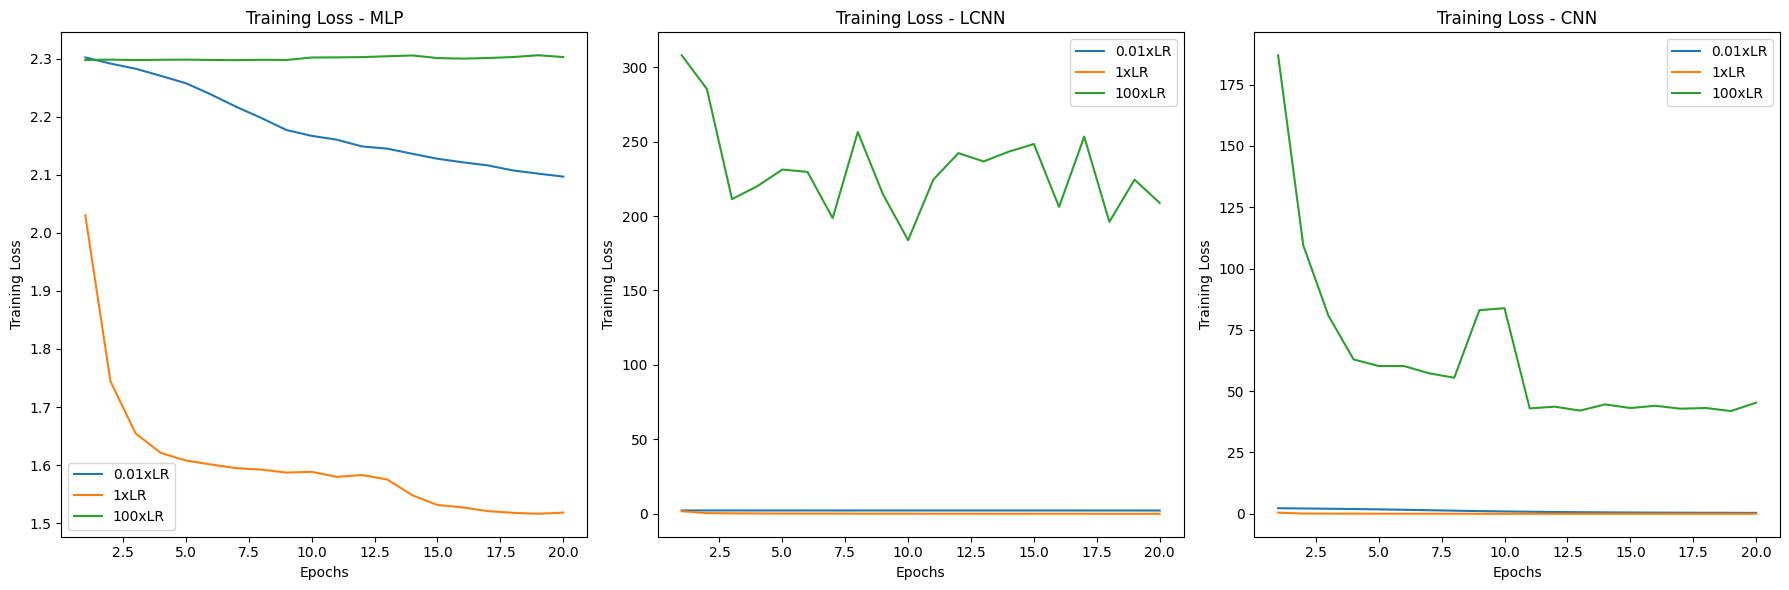

In [ ]:
import matplotlib.pyplot as plt

lrMultipliers = [0.01, 1, 2]

model_names = {1: "MLP", 2: "LCNN", 3: "CNN"}

def TrainWithDifferentLRs(modelType, best_lr, momentum, batch_size, dropout_p):
    results = {}
    loss_logs = {}

    for i in lrMultipliers:
        learningRate = i * best_lr
        print(f"Training {model_names[modelType]} with learning rate: {i}x{best_lr}")

        trainLoader = DataLoader(trainingSet, batch_size=batch_size, shuffle=True)
        valLoader = DataLoader(validationSet, batch_size=batch_size, shuffle=False)

        if modelType == 1:
            W1, b1, W2, b2, W3, b3, W4, b4 = InitializeWeights("effective", modelType)
            trained_parameters, gradient_magnitudes, training_losses = TrainModel(
                W1, b1, W2, b2, W3, b3, W4, b4, learningRate, momentum, batch_size, trainLoader, dropout_p, modelType
            )
            validation_accuracy = ValidateModel(*trained_parameters, valLoader, dropout_p, modelType)

        elif modelType == 2:
            model_lcnn = LocallyConnectedNN(initials="effective", dropout_p=dropout_p)
            trained_model, gradient_magnitudes, training_losses = train_LCNN(model_lcnn, learningRate, momentum, trainLoader)
            validation_accuracy = ValidateLCNN(trained_model, valLoader)

        elif modelType == 3:
            model_cnn = CNNModel(initials="effective", dropout_p=dropout_p)
            trained_model, gradient_magnitudes, training_losses = TrainCNN(model_cnn, learningRate, momentum, trainLoader)
            validation_accuracy = ValidateCNN(trained_model, valLoader)

        print(f"Validation Accuracy for {model_names[modelType]} ({learningRate} LR): {validation_accuracy:.2f}%")

        results[learningRate] = {
            "learning_rate": learningRate,
            "Model": model_names[modelType],
            "gradient_magnitudes": gradient_magnitudes,
            "training_losses": training_losses,
            "validation_accuracy": validation_accuracy
        }

        loss_logs[f"{i}xLR"] = training_losses

    plt.figure(figsize=(8, 6))
    for label, losses in loss_logs.items():
        plt.plot(range(1, len(losses) + 1), losses, label=label)

    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.title(f"Training Loss - {model_names[modelType]}")
    plt.legend()

    filename = f"training_loss_{model_names[modelType]}.png"
    plt.savefig(filename)
    print(f"Saved plot: {filename}")
    plt.close()

    return results, loss_logs

results = {}
loss_logs_all = {}

print("----- Results for MLP -----")
results["MLP"], loss_logs_all["MLP"] = TrainWithDifferentLRs(1, bestFinelr_1, bestFinemom_1, bestFinebs_1, bestFinedropout_1)

print("----- Results for LCNN -----")
results["LCNN"], loss_logs_all["LCNN"] = TrainWithDifferentLRs(2, bestFinelr_2, bestFinemom_2, bestFinebs_2, bestFinedropout_2)

print("----- Results for CNN -----")
results["CNN"], loss_logs_all["CNN"] = TrainWithDifferentLRs(3, bestFinelr_3, bestFinemom_3, bestFinebs_3, bestFinedropout_3)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (model_name, loss_logs) in enumerate(loss_logs_all.items()):
    for label, losses in loss_logs.items():
        axes[i].plot(range(1, len(losses) + 1), losses, label=label)

    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("Training Loss")
    axes[i].set_title(f"Training Loss - {model_name}")
    axes[i].legend()

plt.tight_layout()
plt.savefig("training_loss_comparison.png")
print("Saved plot: training_loss_comparison.png")
plt.show()


# Impact of Batch Size Variations on CNN Training

----- Evaluating Gradient Stability with Different Batch Sizes -----
Training with Batch Size: 8
Epoch 5/20, Loss: 10.919621
Epoch 10/20, Loss: 1.719612
Epoch 15/20, Loss: 1.205150
Epoch 20/20, Loss: 0.906757
Gradient Magnitudes for Batch Size 8:
Epoch 1: 0.513363
Epoch 2: 0.264713
Epoch 3: 0.148266
Epoch 4: 0.091090
Epoch 5: 0.084681
Epoch 6: 0.041743
Epoch 7: 0.031297
Epoch 8: 0.019428
Epoch 9: 0.024122
Epoch 10: 0.014218
Epoch 11: 0.011144
Epoch 12: 0.009181
Epoch 13: 0.009553
Epoch 14: 0.010511
Epoch 15: 0.007305
Epoch 16: 0.007278
Epoch 17: 0.006332
Epoch 18: 0.007707
Epoch 19: 0.007400
Epoch 20: 0.005862
Training with Batch Size: 32
Epoch 5/20, Loss: 6.302642
Epoch 10/20, Loss: 2.129821
Epoch 15/20, Loss: 1.273004
Epoch 20/20, Loss: 0.839757
Gradient Magnitudes for Batch Size 32:
Epoch 1: 0.455971
Epoch 2: 0.279785
Epoch 3: 0.241412
Epoch 4: 0.185784
Epoch 5: 0.165067
Epoch 6: 0.132644
Epoch 7: 0.111615
Epoch 8: 0.101464
Epoch 9: 0.085447
Epoch 10: 0.066946
Epoch 11: 0.059913
Epo

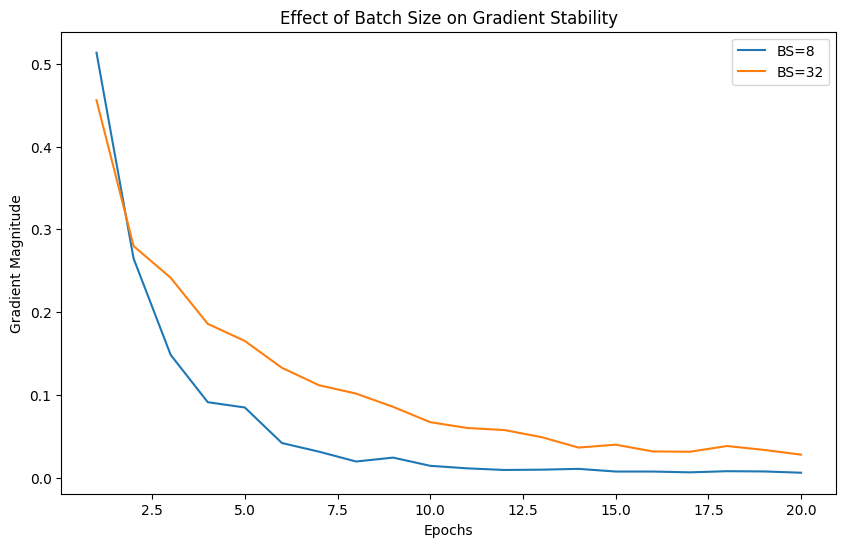

Final Gradient Results:
BS=8: [0.5133627114486848, 0.26471308893957374, 0.14826607134755598, 0.09108996680247072, 0.08468108816347703, 0.041743362296435126, 0.03129737778931411, 0.01942754436239257, 0.024122379735812792, 0.014218198094825748, 0.011143744236460832, 0.009180683289640312, 0.009552734648472491, 0.010510992047784268, 0.0073054464314194914, 0.007278299341741567, 0.0063320544994843585, 0.007706724098697901, 0.007400062326352141, 0.005862175184678455]
BS=32: [0.4559709073923518, 0.27978495203685066, 0.2414117520155011, 0.18578411055928545, 0.1650668935012295, 0.13264355089270052, 0.11161497130301715, 0.10146367014831065, 0.08544665301618448, 0.06694606601183191, 0.05991297809722228, 0.057430557817492206, 0.048860251435705764, 0.03627115493471068, 0.03973713950559772, 0.0315923099283083, 0.031167349696201586, 0.03812124329981407, 0.03345346992812819, 0.027693660080912508]


In [ ]:
import matplotlib.pyplot as plt

def TrainWithDifferentBS_Gradients(model, best_lr, best_mom, best_dropout, batch_sizes):
    gradient_logs = {}

    for batch_size in batch_sizes:
        print(f"Training with Batch Size: {batch_size}")

        trainLoader = DataLoader(trainingSet, batch_size=batch_size, shuffle=True)
        model_copy = CNNModel(initials="effective", dropout_p=best_dropout)
        trained_model, gradient_magnitudes, _= TrainCNN(model_copy, best_lr, best_mom, trainLoader)

        gradient_logs[f"BS={batch_size}"] = gradient_magnitudes

        print(f"Gradient Magnitudes for Batch Size {batch_size}:")
        for epoch, grad in enumerate(gradient_magnitudes, 1):
            print(f"Epoch {epoch}: {grad:.6f}")

    plt.figure(figsize=(10, 6))
    for label, gradients in gradient_logs.items():
        plt.plot(range(1, len(gradients) + 1), gradients, label=label)

    plt.xlabel("Epochs")
    plt.ylabel("Gradient Magnitude")
    plt.title("Effect of Batch Size on Gradient Stability")
    plt.legend()
    plt.savefig("gradient_stability_vs_batch_size.png")
    plt.show()

    return gradient_logs


batches = [8, 32]

print("----- Evaluating Gradient Stability with Different Batch Sizes -----")
gradient_results = TrainWithDifferentBS_Gradients(
    model_cnn, bestFinelr_3, bestFinemom_3, bestFinedropout_3, batches
)

print("Final Gradient Results:")
for batch_size, gradients in gradient_results.items():
    print(f"{batch_size}: {gradients}")


# Impacts of Momentum on CNN Training

----- Evaluating the Impact of Momentum on CNN -----
Training with momentum: 0.5
Epoch 5/20, Loss: 9.616862
Epoch 10/20, Loss: 3.349242
Epoch 15/20, Loss: 1.821172
Epoch 20/20, Loss: 1.220498
Validation Accuracy with Momentum 0.5: 98.36%
Training with momentum: 0.9
Epoch 5/20, Loss: 2.287000
Epoch 10/20, Loss: 0.835327
Epoch 15/20, Loss: 0.479784
Epoch 20/20, Loss: 0.444908
Validation Accuracy with Momentum 0.9: 98.63%
Training with momentum: 0.99
Epoch 5/20, Loss: 2134.111197
Epoch 10/20, Loss: 1759.747377
Epoch 15/20, Loss: 2099.618512
Epoch 20/20, Loss: 2221.455328
Validation Accuracy with Momentum 0.99: 15.63%
Training with momentum: 0.6667243871577918
Epoch 5/20, Loss: 6.764312
Epoch 10/20, Loss: 1.970902
Epoch 15/20, Loss: 1.181085
Epoch 20/20, Loss: 0.652718
Validation Accuracy with Momentum 0.6667243871577918: 98.70%


<Figure size 800x600 with 0 Axes>

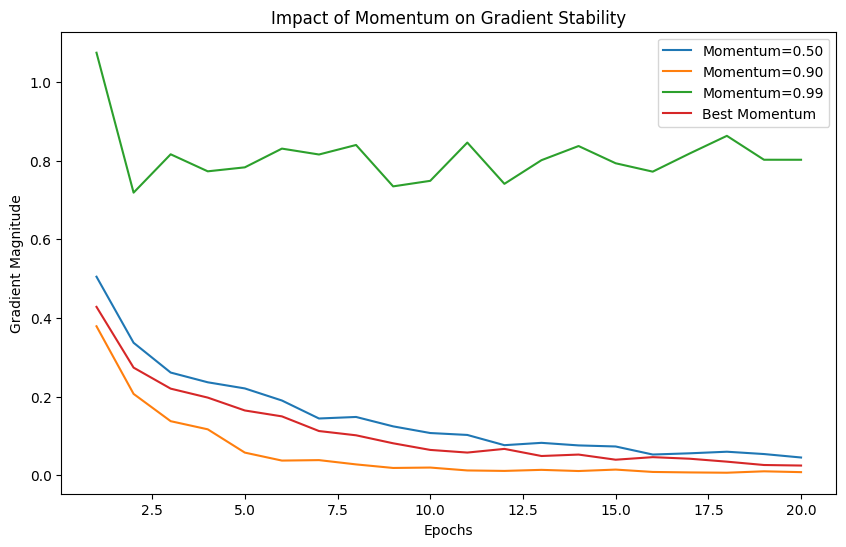

{0.5: {'momentum': 0.5, 'gradient_magnitudes': [0.5049349551561131, 0.3369417494103119, 0.261182381017827, 0.23641672312607098, 0.22081478280446282, 0.19008260921301903, 0.14433888118604996, 0.14822856656035863, 0.12431320403508532, 0.10738116056546843, 0.10250042174241278, 0.07646499803090816, 0.08241065790099014, 0.07587560491220592, 0.07316735864151269, 0.05269224609331556, 0.05581060008499846, 0.05982548822180061, 0.05392429569707775, 0.045123168640003694], 'validation_accuracy': 98.35503769705278}, 0.9: {'momentum': 0.9, 'gradient_magnitudes': [0.3788921504378156, 0.20689869016221893, 0.13751060507141621, 0.11679504302576942, 0.05758222219519716, 0.03729044651015494, 0.0384677326629457, 0.027577140902349875, 0.018530249934018847, 0.019553926834731627, 0.012201489058701593, 0.01102333613787236, 0.013700583115895889, 0.010730542717559072, 0.014390215983816174, 0.008395355678183607, 0.007170327502495897, 0.0064156701869089745, 0.01000679229072502, 0.007891747409422485], 'validation_a

In [ ]:
import matplotlib.pyplot as plt

momValues = [0.5, 0.9, 0.99, bestFinemom_3]

def TrainWithDifferentMom(model, best_lr, best_bs, best_dropout):
    results = {}
    gradient_logs = {}

    plt.figure(figsize=(8, 6))

    for mom in momValues:
        label = f"Momentum={mom:.2f}" if mom != bestFinemom_3 else "Best Momentum"
        print(f"Training with momentum: {mom}")

        trainLoader = DataLoader(trainingSet, batch_size=best_bs, shuffle=True)
        valLoader = DataLoader(validationSet, batch_size=best_bs, shuffle=False)

        model_copy = CNNModel(initials="effective", dropout_p=best_dropout)
        trained_model, gradient_magnitudes, _ = TrainCNN(model_copy, best_lr, mom, trainLoader)
        validation_accuracy = ValidateCNN(trained_model, valLoader)

        print(f"Validation Accuracy with Momentum {mom}: {validation_accuracy:.2f}%")

        results[mom] = {
            "momentum": mom,
            "gradient_magnitudes": gradient_magnitudes,
            "validation_accuracy": validation_accuracy
        }

        gradient_logs[label] = gradient_magnitudes

    plt.figure(figsize=(10, 6))
    for label, gradients in gradient_logs.items():
        plt.plot(range(1, len(gradients) + 1), gradients, label=label)

    plt.xlabel("Epochs")
    plt.ylabel("Gradient Magnitude")
    plt.title("Impact of Momentum on Gradient Stability")
    plt.legend()
    plt.savefig("momentum_gradients.png")
    plt.show()

    return results

print("----- Evaluating the Impact of Momentum on CNN -----")
momentum_results = TrainWithDifferentMom(
    model_cnn, bestFinelr_3, 32, bestFinedropout_3
)

print(momentum_results)


#Impacts of Dropout on MLP Training


----- Evaluating the Impact of Dropout on MLP -----
Training MLP with dropout: 0.0
Epoch 5/20, Loss: 612.762416
Epoch 10/20, Loss: 593.470524
Epoch 15/20, Loss: 569.991663
Epoch 20/20, Loss: 567.925325
Validation Accuracy with Dropout 0.0: 86.36%
Training MLP with dropout: 0.26496862244067554
Epoch 5/20, Loss: 588.810122
Epoch 10/20, Loss: 562.912619
Epoch 15/20, Loss: 554.381749
Epoch 20/20, Loss: 553.203912
Validation Accuracy with Dropout 0.26496862244067554: 93.76%
Training MLP with dropout: 0.99
Epoch 5/20, Loss: 832.832018
Epoch 10/20, Loss: 831.631786
Epoch 15/20, Loss: 831.460100
Epoch 20/20, Loss: 831.033778
Validation Accuracy with Dropout 0.99: 25.22%


<Figure size 800x600 with 0 Axes>

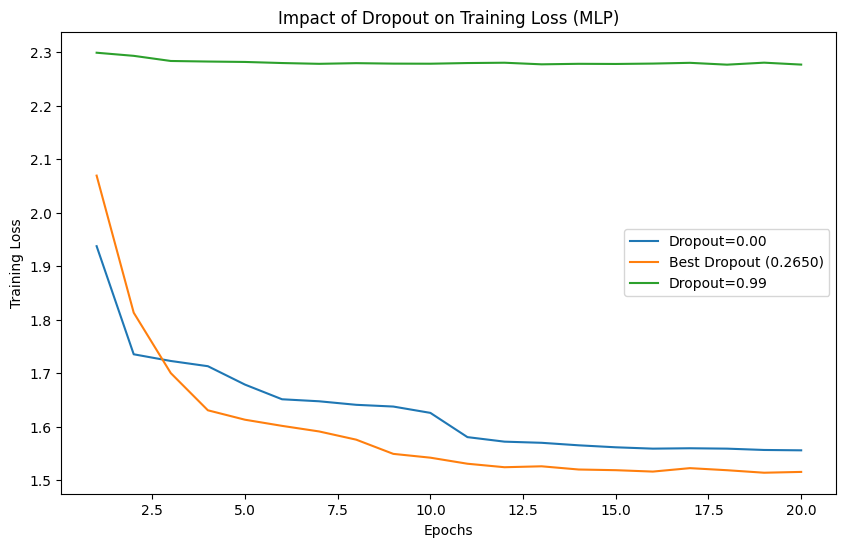

{0.0: {'dropout': 0.0, 'training_losses': [1.9374537040109503, 1.73544043710787, 1.7229271372703656, 1.7131680563704608, 1.678801141046498, 1.6513701775302625, 1.6476135280034314, 1.641020278081502, 1.637779491241664, 1.6259466409683228, 1.580637128385779, 1.5721632562271537, 1.5700253979800498, 1.5653353890327557, 1.5616209951165605, 1.5591068934087884, 1.5598213114150583, 1.5591020744140833, 1.5566338506463455, 1.5559597955991145], 'validation_accuracy': 86.36052090472927}, 0.26496862244067554: {'dropout': 0.26496862244067554, 'training_losses': [2.0693390731942163, 1.81318129644002, 1.7002624028349576, 1.6307844158721296, 1.6131784151678217, 1.6016804329336507, 1.5912413717949228, 1.5759025472484223, 1.5493462866299772, 1.5422263530835714, 1.530916959618869, 1.5243836945050384, 1.526110054695443, 1.5201151047667412, 1.5188541059624658, 1.5162419923364299, 1.522673737186275, 1.5187938118634159, 1.514113058129402, 1.5156271549120341], 'validation_accuracy': 93.76285126799178}, 0.99: {

In [ ]:
import matplotlib.pyplot as plt

dropoutValues = [0.0, bestFinedropout_1, 0.99]

def TrainWithDifferentDropout_MLP(best_lr, best_mom, best_bs):
    results = {}
    loss_logs = {}

    plt.figure(figsize=(8, 6))

    for dropout_p in dropoutValues:
        formatted_dropout = f"{bestFinedropout_1:.4f}"
        label = f"Dropout={dropout_p:.2f}" if dropout_p != bestFinedropout_1 else f"Best Dropout ({formatted_dropout})"

        print(f"Training MLP with dropout: {dropout_p}")

        trainLoader = DataLoader(trainingSet, batch_size=best_bs, shuffle=True)
        valLoader = DataLoader(validationSet, batch_size=best_bs, shuffle=False)
        W1, b1, W2, b2, W3, b3, W4, b4 = InitializeWeights("effective", modelType=1)

        trained_parameters, _, training_losses = TrainModel(
            W1, b1, W2, b2, W3, b3, W4, b4, best_lr, best_mom, best_bs, trainLoader, dropout_p, modelType=1
        )

        validation_accuracy = ValidateModel(*trained_parameters, valLoader, dropout_p, modelType=1)

        print(f"Validation Accuracy with Dropout {dropout_p}: {validation_accuracy:.2f}%")

        results[dropout_p] = {
            "dropout": dropout_p,
            "training_losses": training_losses,
            "validation_accuracy": validation_accuracy
        }

        loss_logs[label] = training_losses

    plt.figure(figsize=(10, 6))
    for label, losses in loss_logs.items():
        plt.plot(range(1, len(losses) + 1), losses, label=label)

    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.title("Impact of Dropout on Training Loss (MLP)")
    plt.legend()
    plt.savefig("dropout_training_loss.png")
    plt.show()

    return results

print("----- Evaluating the Impact of Dropout on MLP -----")
dropout_results = TrainWithDifferentDropout_MLP(bestFinelr_1, bestFinemom_1, bestFinebs_1)

print(dropout_results)
